In [4]:
import numpy as np
import pandas as pd
import copy

import gym
import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
from gym import wrappers

import matplotlib.pyplot as plt
import seaborn

import time
import sys

# suppress warning
import warnings
warnings.filterwarnings('ignore')

# seed
np.random.seed(33)

<h3>Helper Functions</h3>

In [5]:
colors = {
    b'S': 'b',
    b'F': 'w',
    b'H': 'r',
    b'G': 'g'
}

directions = {
            0: '←',
            1: '↓',
            2: '→',
            3: '↑'
}

# plot lake function takes env, using openAI environment.
def plot_lake(env, policy=None, title='Frozen Lake', fig_size=8):
    squares = env.nrow
    fig = plt.figure(figsize=(fig_size, fig_size))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, directions[policy[i, j]],
                               horizontalalignment='center', size=25, verticalalignment='center',
                               color='k')
            
    plt.axis('off')
#     plt.savefig('./frozen/' + title + '.png', dpi=400)
    
#plot_lake(env, policy)

# code used only for small problems
# https://github.com/dxganta/solving_openai/blob/master/FrozenLake8x8/frozenLake8x8.py
def get_score(env, policy, printInfo=False, episodes=100):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        if type(observation) is tuple:
            observation = observation[0]
        steps=0
        while True:
#             print(observation)
# #             print(observation[0])
#             print(policy)
            action = policy[observation]
            observation, reward, terminated, truncated , info = env.step(action)
            steps+=1
            if terminated and reward == 1:
                # print('You have got the Frisbee after {} steps'.format(steps))
                steps_list.append(steps)
                break
            elif terminated and reward == 0:
                # print("You fell in a hole!")
                misses += 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100
    
    if (printInfo):
        print('----------------------------------------------')
        print('You took an average of {:.0f} steps to get the frisbee'.format(ave_steps))
        print('And you fell in the hole {:.2f} % of the times'.format(pct_fail))
        print('----------------------------------------------')
  
    return ave_steps, std_steps, pct_fail


def vi_plots(data_df,xAttr,xList):
    #steps
    x = xList
    y = []
    for g in xList:
        y.append(data_df.loc[data_df[xAttr] == g]['average_steps'].mean())
    sigma = []
    for g in xList:
        sigma.append(data_df.loc[data_df[xAttr] == g]['average_steps'].std())
    max = []
    for g in xList:
        max.append(data_df.loc[data_df[xAttr] == g]['average_steps'].max())


    #time
    time = []
    for g in xList:
        time.append(data_df.loc[data_df[xAttr] == g]['time'].mean())
    t_sigma = []
    for g in xList:
        t_sigma.append(data_df.loc[data_df[xAttr] == g]['time'].std())
    t_max = []
    for g in xList:
        t_max.append(data_df.loc[data_df[xAttr] == g]['time'].max())


    #reward
    reward = []
    for g in xList:
        reward.append(data_df.loc[data_df[xAttr] == g]['reward'].mean())
    r_sigma = []
    for g in xList:
        r_sigma.append(data_df.loc[data_df[xAttr] == g]['reward'].std())
    r_max = []
    for g in xList:
        r_max.append(data_df.loc[data_df[xAttr] == g]['reward'].max())


    #success
    success = []
    for g in xList:
        success.append(data_df.loc[data_df[xAttr] == g]['success_pct'].mean())
    s_sigma = []
    for g in xList:
        s_sigma.append(data_df.loc[data_df[xAttr] == g]['success_pct'].std())
    s_max = []
    for g in xList:
        s_max.append(data_df.loc[data_df[xAttr] == g]['success_pct'].max())

        
    #iteration
    iterations = []
    for g in xList:
        iterations.append(data_df.loc[data_df[xAttr] == g]['iterations'].mean())
    i_sigma = []
    for g in xList:
        i_sigma.append(data_df.loc[data_df[xAttr] == g]['iterations'].std())
    i_max = []
    for g in xList:
        i_max.append(data_df.loc[data_df[xAttr] == g]['iterations'].max())
        

    fig = plt.figure(figsize=(6,4))
    plt.plot(x, y, 'o-', label='Average Steps')
    plt.plot(x, max, 'o--', label='Max Steps')
    plt.fill_between(x, np.array(y)-np.array(sigma), np.array(y)+np.array(sigma), color='b', alpha=0.1)

    plt.title('Average/Max Steps Taken vs. Gamma')
    plt.xlabel(xAttr)
    plt.legend(loc='best')
    plt.ylabel('Steps')
    plt.grid(True)
    plt.show()


    fig = plt.figure(figsize=(6,4))
    plt.plot(x, reward, 'o-', label='Average Reward')
    plt.plot(x, r_max, 'o--', label='Max Reward')
    plt.fill_between(x, np.array(reward)-np.array(r_sigma), np.array(reward)+np.array(r_sigma), color='b', alpha=0.1)

    plt.title('Average/Max Reward vs. Gamma')
    plt.xlabel(xAttr)
    plt.legend(loc='best')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.show()

    fig = plt.figure(figsize=(6,4))
    plt.plot(x, time, 'o-', label='Average time')
    plt.plot(x, t_max, 'o--', label='Max time')
    plt.fill_between(x, np.array(time)-np.array(t_sigma), np.array(time)+np.array(t_sigma), color='b', alpha=0.1)

    plt.title('Average/Max Time Taken vs. Gamma')
    plt.xlabel(xAttr)
    plt.legend(loc='best')
    plt.ylabel('Time')
    plt.grid(True)
    plt.show()

    fig = plt.figure(figsize=(6,4))
    plt.plot(x, success, 'o-', label='Average Success PCT')
    plt.plot(x, s_max, 'o--', label='Max Success PCT')
    plt.fill_between(x, np.array(success)-np.array(s_sigma), np.array(success)+np.array(s_sigma), color='b', alpha=0.1)

    plt.title('Average/Max Success PCT vs. Gamma')
    plt.xlabel(xAttr)
    plt.legend(loc='best')
    plt.ylabel('Success PCT')
    plt.grid(True)
    plt.show()
    
    fig = plt.figure(figsize=(6,4))
    plt.plot(x, iterations, 'o-', label='Average Iterations')
    plt.plot(x, i_max, 'o--', label='Max Iterations')
    plt.fill_between(x, np.array(iterations)-np.array(i_sigma), np.array(iterations)+np.array(i_sigma), color='b', alpha=0.1)

    plt.title('Average/Max Iterations vs. Gamma')
    plt.xlabel(xAttr)
    plt.legend(loc='best')
    plt.ylabel('Iterations')
    plt.grid(True)
    plt.show()


def pi_plots(data_df,xAttr,xList):
    #steps
    x = xList
    y = data_df['average_steps']
    sigma = data_df['steps_stddev']

    #time
    time = data_df['time']
    
    #reward
    reward = data_df['reward']

    #success
    success = data_df['success_pct']
    
    #iterations
    iterations = data_df['iterations']



    fig = plt.figure(figsize=(6,4))
    plt.plot(x, y, 'o-', label='Steps')
    plt.fill_between(x, np.array(y)-np.array(sigma), np.array(y)+np.array(sigma), color='b', alpha=0.1)

    plt.title('Steps Taken vs. Gamma')
    plt.xlabel(xAttr)
    plt.ylabel('Steps')
    plt.grid(True)
    plt.show()


    fig = plt.figure(figsize=(6,4))
    plt.plot(x, reward, 'o-', label='Reward')
    plt.title('Reward vs. Gamma')
    plt.xlabel(xAttr)
    plt.ylabel('Reward')
    plt.grid(True)
    plt.show()

    fig = plt.figure(figsize=(6,4))
    plt.plot(x, time, 'o-', label='Time')
    plt.title('Time Taken vs. Gamma')
    plt.xlabel(xAttr)
    plt.ylabel('Time')
    plt.grid(True)
    plt.show()

    fig = plt.figure(figsize=(6,4))
    plt.plot(x, success, 'o-', label='Success PCT')
    plt.title('Success PCT vs. Gamma')
    plt.xlabel(xAttr)
    plt.ylabel('Success PCT')
    plt.grid(True)
    plt.show()
    
    fig = plt.figure(figsize=(6,4))
    plt.plot(x, iterations, 'o-', label='Iterations')
    plt.title('iterations vs. Gamma')
    plt.xlabel(xAttr)
    plt.ylabel('iterations')
    plt.grid(True)
    plt.show()

def make_time_array(run_stats, variables):
    cumulative_sum = 0
    times = []
    output_dict = {v:[] for v in variables}
    output_dict["times"] = times
    for result in run_stats:
        times.append(result["Time"])
        for v in result:
            if v in variables:
                output_dict[v].append(result[v])
    return output_dict

def plot_simple_data(x_var, y_var, x_label, y_label, title, figure_size=(4,3)):
    plt.rcParams["figure.figsize"] = figure_size
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot(x_var, y_var, 'o-')
    plt.grid(True)
    plt.show()

    
# directions = {
#             0: '←',
#             1: '↓',
#             2: '→',
#             3: '↑'
# }

colors = {
    b'S': 'b',
    b'F': 'w',
    b'H': 'r',
    b'G': 'g'
}
def fancy_visual(value_func,policy_str, grid=4, env=None, title=None, fig_size_l=11, fig_size_w=9, save=False):
    if title == None:
        title= 'Heatmap with policy, value Function and directions'
    f, ax = plt.subplots(figsize=(fig_size_l, fig_size_w))
    cmap =  seaborn.light_palette("seagreen", as_cmap=True) #seaborn.diverging_palette(220, 10, as_cmap=True)
    reshaped=np.reshape(value_func,(grid,grid))
    seaborn.heatmap(reshaped, cmap=cmap, vmax=1.1,
                square=True,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt=".3f")
    counter=0
    for j in range(0, grid):
        for i in range(0, grid):
#             print(j)
#             print(i)
#             print(env.desc[j,i])
            if env:
                x = grid - i - 1
                y = j
#                 print(colors[env.desc[j,i]])
                if colors[env.desc[j,i]] != 'w':
                    p = plt.Rectangle([i, j], 1, 1, linewidth=1, edgecolor='k')
                    p.set_facecolor(colors[env.desc[j,i]])
                    ax.add_patch(p)
            if policy_str[counter]==1:
                plt.text(i+0.5, j+0.7, u'\u2193', fontsize=12)
            elif policy_str[counter]==3:
                plt.text(i+0.5, j+0.7, u'\u2191', fontsize=12)
            elif policy_str[counter]==0:
                plt.text(i+0.5, j+0.7, u'\u2190', fontsize=12)
            else:
                plt.text(i+0.5, j+0.7, u'\u2192', fontsize=12)
            counter=counter+1

    plt.title(title)
    if save:
        plt.savefig('hmaplarge.png')


<h3>Build ENvironments</h3>

In [6]:
# import hiive.mdptoolbox.example
# from gym.envs.toy_text.frozen_lake import generate_random_map
# random_map = generate_random_map(size=4, p=0.98)
# T, R = hiive.mdptoolbox.example.openai("FrozenLake-v1", desc=random_map)

# print(T)
# print(R)

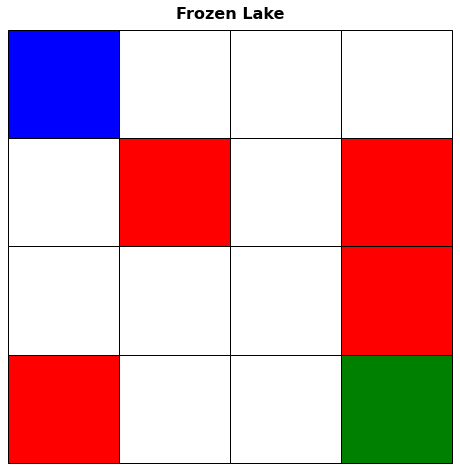

In [7]:
# Setup 4x4
# env4 = gym.make('FrozenLake-v1', is_slippery=True).unwrapped #FrozenLake8x8-v1
env4 = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True).unwrapped

env4.max_episode_steps=250

# Create transition and reward matrices from OpenAI P matrix
rows = env4.nrow
cols = env4.ncol
FL4_T = np.zeros((4, rows*cols, rows*cols))
FL4_R = np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env4.P:
    for action in env4.P[square]:
        for i in range(len(env4.P[square][action])):
            new_state = env4.P[square][action][i][1]
            if new_state == old_state:
                FL4_T[action][square][env4.P[square][action][i][1]] = FL4_T[action][square][old_state] + env4.P[square][action][i][0]
                FL4_R[action][square][env4.P[square][action][i][1]] = FL4_R[action][square][old_state] + env4.P[square][action][i][2]
            else:
                FL4_T[action][square][env4.P[square][action][i][1]] = env4.P[square][action][i][0]
                FL4_R[action][square][env4.P[square][action][i][1]] = env4.P[square][action][i][2]
            old_state = env4.P[square][action][i][1]
            
#print(T)
#print(R)
plot_lake(env4)

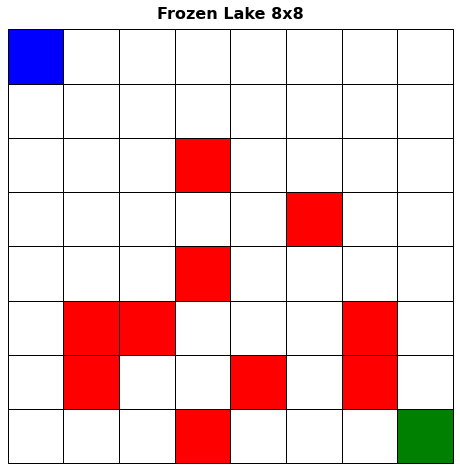

In [24]:
# Setup 4x4
env8 = gym.make('FrozenLake8x8-v1', is_slippery=True).unwrapped #FrozenLake8x8-v1

# env8.max_episode_steps=250

# Create transition and reward matrices from OpenAI P matrix
rows = env8.nrow
cols = env8.ncol
FL8_T = np.zeros((4, rows*cols, rows*cols))
FL8_R = np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env8.P:
    for action in env8.P[square]:
        for i in range(len(env8.P[square][action])):
            new_state = env8.P[square][action][i][1]
            if new_state == old_state:
                FL8_T[action][square][env8.P[square][action][i][1]] = FL8_T[action][square][old_state] + env8.P[square][action][i][0]
                FL8_R[action][square][env8.P[square][action][i][1]] = FL8_R[action][square][old_state] + env8.P[square][action][i][2]
            else:
                FL8_T[action][square][env8.P[square][action][i][1]] = env8.P[square][action][i][0]
                FL8_R[action][square][env8.P[square][action][i][1]] = env8.P[square][action][i][2]
            old_state = env8.P[square][action][i][1]
            
#print(T)
#print(R)
plot_lake(env8, policy=None, title='Frozen Lake 8x8', fig_size=8)

<h3> Negative Rewards </h3>

In [9]:
FL8_R_N = copy.deepcopy(FL8_R)
where_0 = np.where(FL8_R_N == 0)
where_1 = np.where(FL8_R_N == 1)

FL8_R_N[where_0] = -1
FL8_R_N[where_1] = 1000000

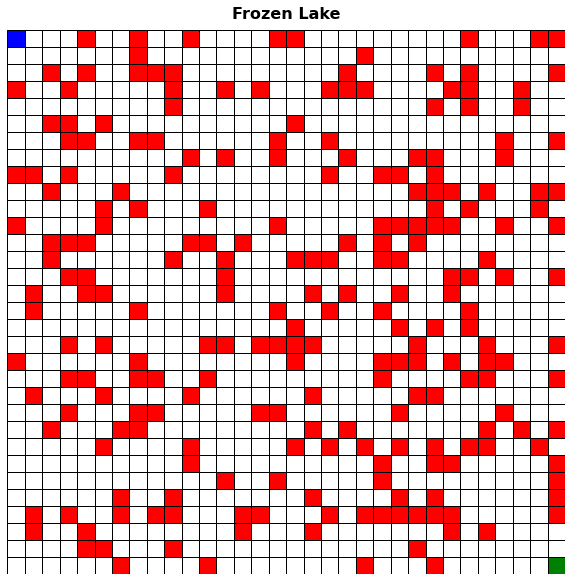

In [10]:
#16 states.
import hiive.mdptoolbox.example
from gym.envs.toy_text.frozen_lake import generate_random_map
np.random.seed(33)
env32_2 = gym.make('FrozenLake-v1', desc=generate_random_map(size=32)).unwrapped

# Create transition and reward matrices from OpenAI P matrix
rows = env32_2.nrow
cols = env32_2.ncol
FL322_T = np.zeros((4, rows*cols, rows*cols))
FL322_R = np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env32_2.P:
    for action in env32_2.P[square]:
        for i in range(len(env32_2.P[square][action])):
            new_state = env32_2.P[square][action][i][1]
            if new_state == old_state:
                FL322_T[action][square][env32_2.P[square][action][i][1]] = FL322_T[action][square][old_state] + env32_2.P[square][action][i][0]
                FL322_R[action][square][env32_2.P[square][action][i][1]] = FL322_R[action][square][old_state] + env32_2.P[square][action][i][2]
            else:
                FL322_T[action][square][env32_2.P[square][action][i][1]] = env32_2.P[square][action][i][0]
                FL322_R[action][square][env32_2.P[square][action][i][1]] = env32_2.P[square][action][i][2]
            old_state = env32_2.P[square][action][i][1]
            
            
plot_lake(env32_2, fig_size=10)

In [11]:
#Negative reward for 32x32
FL322_R_N = copy.deepcopy(FL322_R)
where_0 = np.where(FL322_R_N == 0)
where_1 = np.where(FL322_R_N == 1)

FL322_R_N[where_0] = -0.001
FL322_R_N[where_1] = 1000

In [12]:
# from gym.envs.toy_text.frozen_lake import generate_random_map
# env16 = gym.make('FrozenLake-v1', desc=generate_random_map(size=32))

import hiive.mdptoolbox.example
from gym.envs.toy_text.frozen_lake import generate_random_map
random_map = generate_random_map(size=32, p=0.98)
FL32_T, FL32_R = hiive.mdptoolbox.example.openai("FrozenLake-v1", desc=random_map)

print(FL32_T.shape)
print(FL32_R.shape)



(4, 1024, 1024)
(1024, 4)


<h3>Value Iteration</h3>

In [199]:
def valueIteration(t, r, gammas, epsilons, showResults=False, max_iterations=100000, policy_stat=True, p_size=4):
    env_p = env4
    if p_size ==8:
        env_p = env8
    if p_size ==16:
        env_p = env32_2
    t0 = time.time()
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)*len(epsilons)), columns=columns)
    
    print('Gamma,\tEps,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for e in epsilons:
            test = ValueIteration(t, r, gamma=g, epsilon=e, max_iter=max_iterations)
            
#                         Attributes (Data) –
# ————— –
# V (tuple) – The optimal value function.
# policy (tuple) – The optimal policy function. Each element is an integer corresponding to an action which maximises the value function in that state.
# iter (int) – The number of iterations taken to complete the computation.
# time (float) – The amount of CPU time used to run the algorithm.

            runs  = test.run()
#             print(runs)
#             print('vip')
            Time  = runs[-1]['Time']
            iters = runs[-1]['Iteration']
            maxR  = runs[-1]['Max V']
            
            
            max_rewards, mean_rewards, errors = [], [], []
            for run in runs:
                max_rewards.append(run['Max V'])
                mean_rewards.append(run['Mean V'])
                errors.append(run['Error'])
            
            policy = np.array(test.policy)
            policy = policy.reshape(p_size,p_size)
            
            data['gamma'][testNum]        = g
            data['epsilon'][testNum]      = e
            data['time'][testNum]         = Time
            data['iterations'][testNum]   = iters
            data['reward'][testNum]       = maxR
            data['mean_rewards'][testNum] = {tuple(mean_rewards)}
            data['max_rewards'][testNum]  = {tuple(max_rewards)}
            data['error'][testNum]        = {tuple(errors)}
            data['policy'][testNum]       = {test.policy}
            
            print('%.2f,\t%.0E,\t%.2f,\t%d,\t%f' % (g, e, Time, iters, maxR))
            
            if showResults:
                title = 'FrozenLake_VI_' + str(rows) + 'x' + str(cols) + '_g' + str(g) + '_e' + str(e)
                
                
                plot_lake(env_p, policy, title)
            
            testNum = testNum + 1
                
    endTime = time.time() - t0
    print("Time taken: %.2f" %endTime)
    
    if policy_stat:
        # See differences in policy
        policies = data['policy']

        # now to get data for the other graphs. 

        for i,p in enumerate(policies):
            pol = list(p)[0]
    #         print(i)
    #         print(p)
            steps, steps_stddev, failures = get_score(env_p, pol, showResults)
            data['average_steps'][i] = steps
            data['steps_stddev'][i]  = steps_stddev
            data['success_pct'][i]   = 100-failures      
        
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

In [200]:
gammas   = [0.3, 0.6, 0.9, 0.99, 0.999]
epsilons = [1e-2, 1e-4, 1e-5, 1e-6]
vi_data_FL4  = valueIteration(FL4_T, FL4_R, gammas, epsilons, showResults=False, policy_stat=True, p_size=4)

# interest = ['gamma', 'epsilon', 'time', 'iterations', 'reward']
# df = vi_data[interest]
# df.to_csv('frozen/VI_convergence.csv')

# vi_data_FL4.head()

Gamma,	Eps,	Time,	Iter,	Reward
________________________________________________________________________________
0.30,	1E-02,	0.00,	3,	0.373333
0.30,	1E-04,	0.00,	7,	0.375096
0.30,	1E-05,	0.00,	8,	0.375101
0.30,	1E-06,	0.00,	10,	0.375103
0.60,	1E-02,	0.00,	5,	0.442667
0.60,	1E-04,	0.00,	12,	0.447600
0.60,	1E-05,	0.00,	16,	0.447645
0.60,	1E-06,	0.00,	20,	0.447649
0.90,	1E-02,	0.00,	10,	0.614142
0.90,	1E-04,	0.00,	44,	0.638900
0.90,	1E-05,	0.00,	61,	0.639008
0.90,	1E-06,	0.00,	78,	0.639019
0.99,	1E-02,	0.00,	30,	0.813050
0.99,	1E-04,	0.01,	172,	0.862484
0.99,	1E-05,	0.01,	238,	0.862801
0.99,	1E-06,	0.01,	305,	0.862834
1.00,	1E-02,	0.00,	39,	0.860979
1.00,	1E-04,	0.01,	234,	0.930694
1.00,	1E-05,	0.02,	324,	0.931130
1.00,	1E-06,	0.02,	414,	0.931174
Time taken: 0.15


In [13]:
#  Plot most successful gamma and epsilon

# find the score with the highest success percentage and get its policy
bestRun = vi_data_FL4['reward'].argmax()
best_policy = vi_data_FL4['policy'][bestRun]
best_policy = np.array(list(best_policy)[0])
best_policy = best_policy.reshape(4, 4)

# write all results to csv file
# csvFile = 'frozen/VI_results.csv'
# vi_data.to_csv(csvFile)

print('Best Result:\n\tSuccess = %.2f\n\tGamma = %.2f\n\tEpsilon= %.E' % (vi_data_FL4['success_pct'][bestRun], vi_data_FL4['gamma'][bestRun], vi_data_FL4['epsilon'][bestRun]))

Best Result:
	Success = 85.00
	Gamma = 1.00
	Epsilon= 1E-12


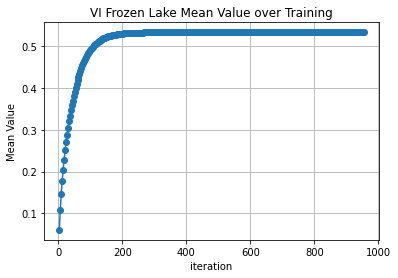

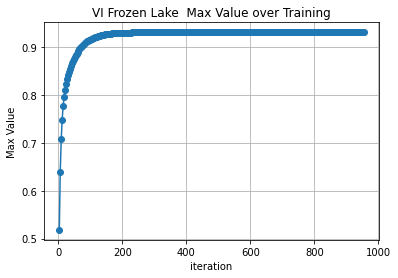

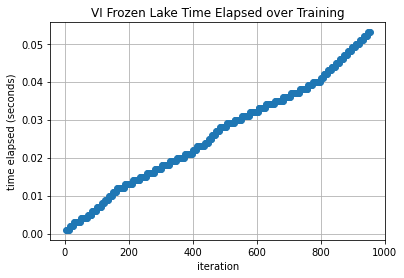

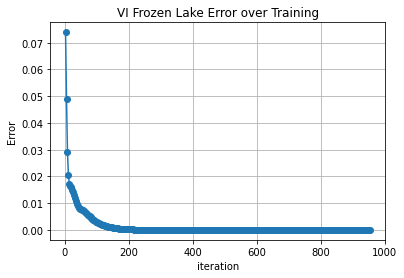

In [166]:
#plot Best Run
fl4_vi = ValueIteration(FL4_T, FL4_R, gamma=0.999, epsilon=1e-12,max_iter=100000)
fl4_vi.run()
fl4_vi_curated_results = make_time_array(fl4_vi.run_stats, ["Mean V", "Max V", "Iteration", "Error"])
num_iters = len(fl4_vi_curated_results["Mean V"])
plot_simple_data(fl4_vi_curated_results["Iteration"], fl4_vi_curated_results["Mean V"], 
                 "iteration", "Mean Value", "VI Frozen Lake Mean Value over Training", figure_size=(6,4))
plot_simple_data(fl4_vi_curated_results["Iteration"], fl4_vi_curated_results["Max V"], 
                 "iteration", "Max Value", "VI Frozen Lake  Max Value over Training", figure_size=(6,4))
plot_simple_data(fl4_vi_curated_results["Iteration"], fl4_vi_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "VI Frozen Lake Time Elapsed over Training", figure_size=(6,4))
plot_simple_data(fl4_vi_curated_results["Iteration"], fl4_vi_curated_results["Error"], 
                 "iteration", "Error", "VI Frozen Lake Error over Training", figure_size=(6,4))

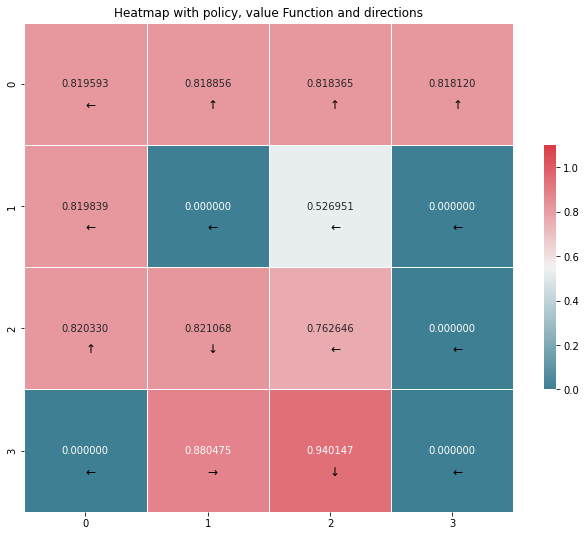

In [157]:
fancy_visual(fl4_vi.V,fl4_vi.policy,grid=4) 

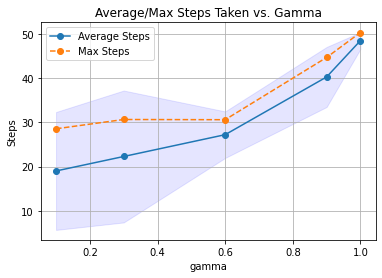

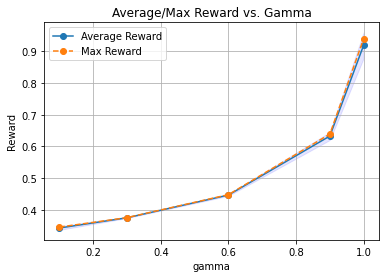

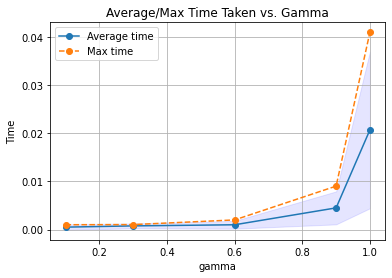

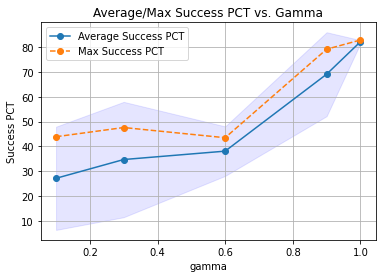

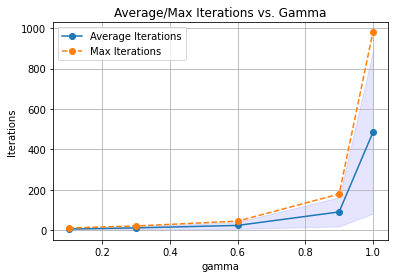

In [167]:
vi_plots(vi_data_FL4,'gamma',gammas)

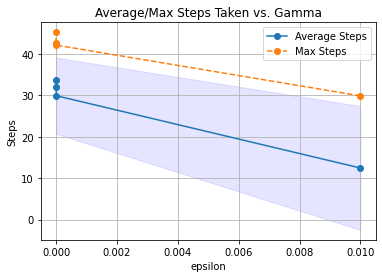

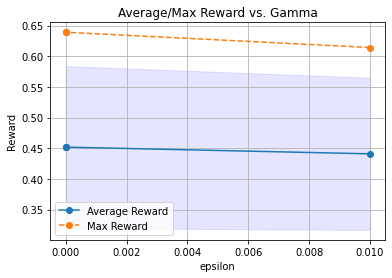

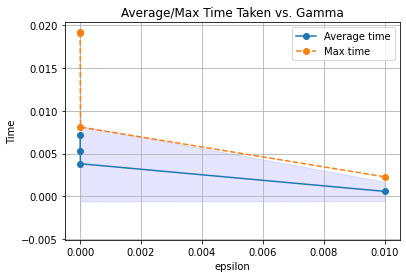

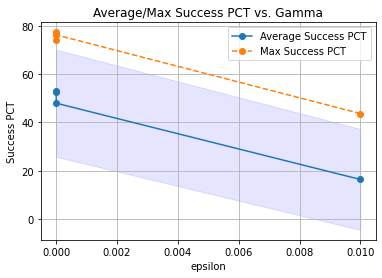

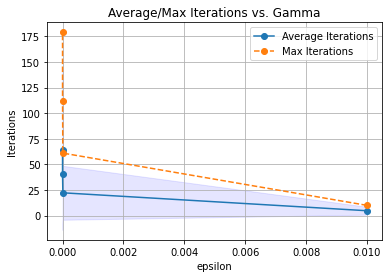

In [79]:
vi_plots(vi_data_FL4,'epsilon',epsilons)

In [213]:
gammas   = [0.3, 0.6, 0.9, 0.99, 0.999]
epsilons = [1e-2, 1e-4, 1e-5, 1e-6]
vi_data_FL8  = valueIteration(FL8_T, FL8_R, gammas, epsilons, showResults=False, policy_stat=False, p_size=8)
#  Plot most successful gamma and epsilon

# find the score with the highest success percentage and get its policy/
bestRun = vi_data_FL8['reward'].argmax()
best_policy = vi_data_FL8['policy'][bestRun]
best_policy = np.array(list(best_policy)[0])
best_policy = best_policy.reshape(8, 8)

# write all results to csv file
csvFile = 'frozen/VI_results.csv'
# vi_data.to_csv(csvFile)

print('Best Result:\n\tSuccess = %.2f\n\tGamma = %.2f\n\tEpsilon= %.E' % (vi_data_FL8['success_pct'][bestRun], vi_data_FL8['gamma'][bestRun], vi_data_FL8['epsilon'][bestRun]))

Gamma,	Eps,	Time,	Iter,	Reward
________________________________________________________________________________
0.30,	1E-02,	0.00,	3,	0.373333
0.30,	1E-04,	0.00,	6,	0.375037
0.30,	1E-05,	0.00,	8,	0.375058
0.30,	1E-06,	0.00,	10,	0.375059
0.60,	1E-02,	0.00,	5,	0.442133
0.60,	1E-04,	0.00,	12,	0.446539
0.60,	1E-05,	0.00,	16,	0.446584
0.60,	1E-06,	0.00,	20,	0.446588
0.90,	1E-02,	0.00,	10,	0.604898
0.90,	1E-04,	0.00,	46,	0.630385
0.90,	1E-05,	0.00,	66,	0.630505
0.90,	1E-06,	0.00,	86,	0.630513
0.99,	1E-02,	0.00,	33,	0.812082
0.99,	1E-04,	0.01,	221,	0.877600
0.99,	1E-05,	0.02,	296,	0.877753
0.99,	1E-06,	0.02,	370,	0.877767
1.00,	1E-02,	0.00,	57,	0.897402
1.00,	1E-04,	0.02,	405,	0.980822
1.00,	1E-05,	0.03,	579,	0.981122
1.00,	1E-06,	0.04,	736,	0.981141
Time taken: 0.23
Best Result:
	Success = 0.00
	Gamma = 1.00
	Epsilon= 1E-06


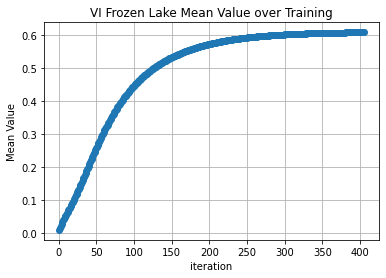

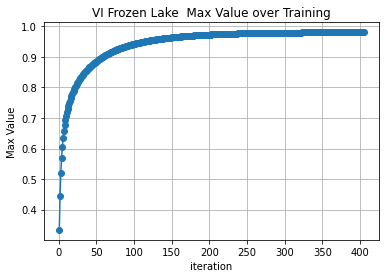

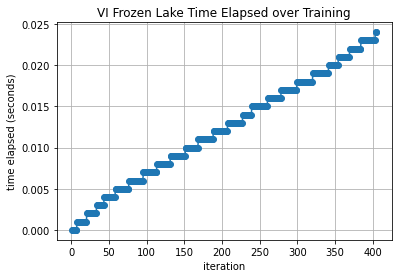

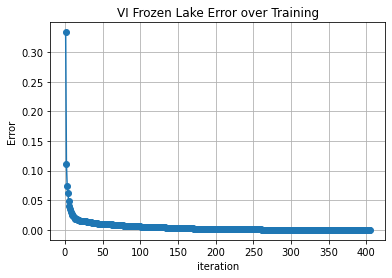

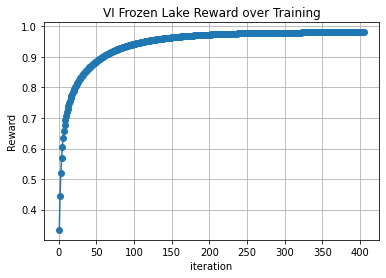

In [137]:
#plot Best Run
fl8_vi = ValueIteration(FL8_T, FL8_R, gamma=0.999, epsilon=1e-4,max_iter=10000)
fl8_vi.run()
fl8_vi_curated_results = make_time_array(fl8_vi.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
num_iters = len(fl8_vi_curated_results["Mean V"])
plot_simple_data(fl8_vi_curated_results["Iteration"], fl8_vi_curated_results["Mean V"], 
                 "iteration", "Mean Value", "VI Frozen Lake Mean Value over Training", figure_size=(6,4))
plot_simple_data(fl8_vi_curated_results["Iteration"], fl8_vi_curated_results["Max V"], 
                 "iteration", "Max Value", "VI Frozen Lake  Max Value over Training", figure_size=(6,4))
plot_simple_data(fl8_vi_curated_results["Iteration"], fl8_vi_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "VI Frozen Lake Time Elapsed over Training", figure_size=(6,4))
plot_simple_data(fl8_vi_curated_results["Iteration"], fl8_vi_curated_results["Error"], 
                 "iteration", "Error", "VI Frozen Lake Error over Training", figure_size=(6,4))
plot_simple_data(fl8_vi_curated_results["Iteration"], fl8_vi_curated_results["Reward"], 
                 "iteration", "Reward", "VI Frozen Lake Reward over Training", figure_size=(6,4))

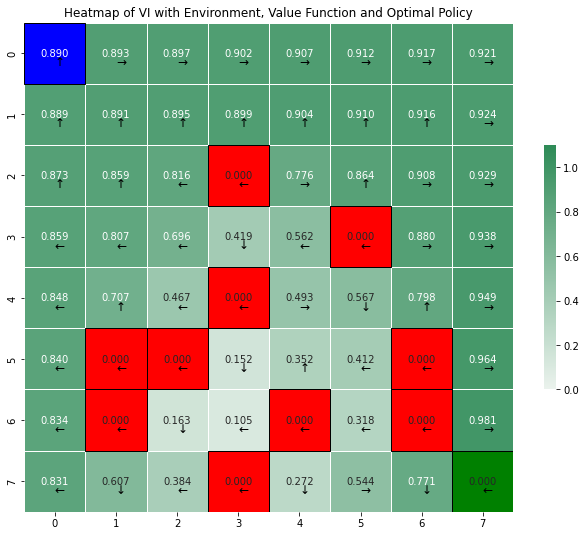

In [151]:
title= 'Heatmap of VI with Environment, Value Function and Optimal Policy'
fancy_visual(fl8_vi.V,fl8_vi.policy,grid=8,env=env8,title=title) 

<h3> Negative Reward 8x8</h3>

In [210]:
gammas   = [0.3, 0.6, 0.9, 0.99, 0.999]
epsilons = [1e-2, 1e-4, 1e-5, 1e-6]
vi_data_FL8_N  = valueIteration(FL8_T, FL8_R_N, gammas, epsilons, showResults=False, policy_stat=False, p_size=8)
#  Plot most successful gamma and epsilon

# find the score with the highest success percentage and get its policy/
bestRun = vi_data_FL8_N['reward'].argmax()
best_policy = vi_data_FL8_N['policy'][bestRun]
best_policy = np.array(list(best_policy)[0])
best_policy = best_policy.reshape(8, 8)


print('Best Result:\n\tSuccess = %.2f\n\tGamma = %.2f\n\tEpsilon= %.E' % (vi_data_FL8_N['success_pct'][bestRun], vi_data_FL8_N['gamma'][bestRun], vi_data_FL8_N['epsilon'][bestRun]))

Gamma,	Eps,	Time,	Iter,	Reward
________________________________________________________________________________
0.30,	1E-02,	0.00,	8,	374.004480
0.30,	1E-04,	0.00,	12,	374.005843
0.30,	1E-05,	0.00,	14,	374.005849
0.30,	1E-06,	0.00,	15,	374.005849
0.60,	1E-02,	0.00,	16,	444.530841
0.60,	1E-04,	0.00,	25,	444.534757
0.60,	1E-05,	0.00,	29,	444.534776
0.60,	1E-06,	0.00,	34,	444.534778
0.90,	1E-02,	0.00,	65,	621.144801
0.90,	1E-04,	0.00,	103,	621.144440
0.90,	1E-05,	0.01,	121,	621.144335
0.90,	1E-06,	0.01,	137,	621.144317
0.99,	1E-02,	0.02,	460,	779.628593
0.99,	1E-04,	0.05,	918,	778.656351
0.99,	1E-05,	0.06,	1147,	778.647493
0.99,	1E-06,	0.07,	1376,	778.646607
1.00,	1E-02,	0.25,	4604,	-7.887722
1.00,	1E-04,	0.49,	9206,	-17.776422
1.00,	1E-05,	0.60,	11508,	-17.866403
1.00,	1E-06,	0.73,	13810,	-17.875397
Time taken: 2.39
Best Result:
	Success = 0.00
	Gamma = 0.99
	Epsilon= 1E-02


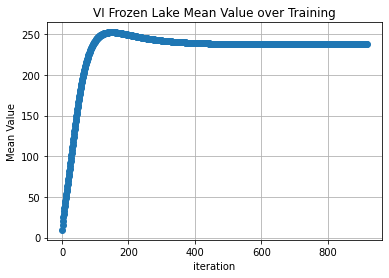

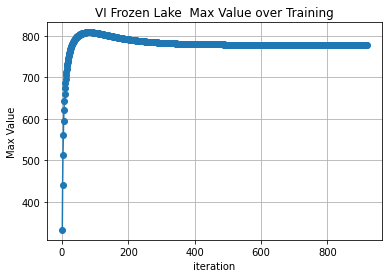

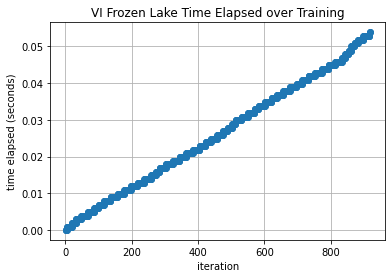

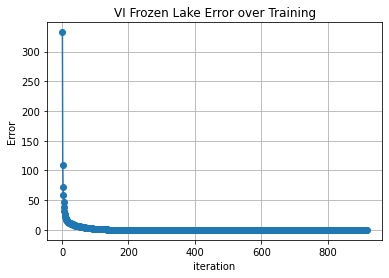

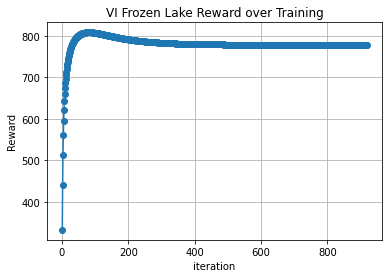

In [143]:
#plot Best Run
fl8_vi_N = ValueIteration(FL8_T, FL8_R_N, gamma=0.99, epsilon=1e-4,max_iter=10000)
fl8_vi_N.run()
fl8_vi_N_curated_results = make_time_array(fl8_vi_N.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
num_iters = len(fl8_vi_N_curated_results["Mean V"])
plot_simple_data(fl8_vi_N_curated_results["Iteration"], fl8_vi_N_curated_results["Mean V"], 
                 "iteration", "Mean Value", "VI Frozen Lake Mean Value over Training", figure_size=(6,4))
plot_simple_data(fl8_vi_N_curated_results["Iteration"], fl8_vi_N_curated_results["Max V"], 
                 "iteration", "Max Value", "VI Frozen Lake  Max Value over Training", figure_size=(6,4))
plot_simple_data(fl8_vi_N_curated_results["Iteration"], fl8_vi_N_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "VI Frozen Lake Time Elapsed over Training", figure_size=(6,4))
plot_simple_data(fl8_vi_N_curated_results["Iteration"], fl8_vi_N_curated_results["Error"], 
                 "iteration", "Error", "VI Frozen Lake Error over Training", figure_size=(6,4))
plot_simple_data(fl8_vi_N_curated_results["Iteration"], fl8_vi_N_curated_results["Reward"], 
                 "iteration", "Reward", "VI Frozen Lake Reward over Training", figure_size=(6,4))

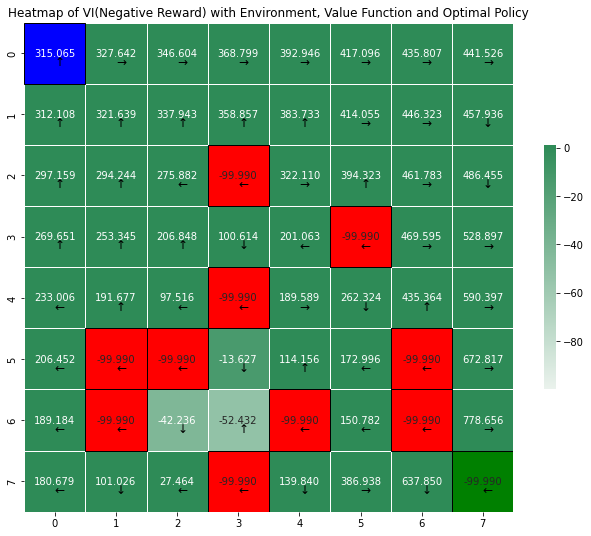

In [152]:
title= 'Heatmap of VI(Negative Reward) with Environment, Value Function and Optimal Policy'
fancy_visual(fl8_vi_N.V,fl8_vi_N.policy,grid=8,env=env8,title=title) 

In [206]:
gammas   = [0.3, 0.6, 0.9, 0.99, 0.999]
epsilons = [1e-2, 1e-4, 1e-5, 1e-6]
vi_data_FL32  = valueIteration(FL322_T, FL322_R, gammas, epsilons, showResults=False, policy_stat=False, p_size=32)
#  Plot most successful gamma and epsilon

# find the score with the highest success percentage and get its policy/
bestRun = vi_data_FL32['reward'].argmax()
best_policy = vi_data_FL32['policy'][bestRun]
best_policy = np.array(list(best_policy)[0])
best_policy = best_policy.reshape(32, 32)

# write all results to csv file
csvFile = 'frozen/VI_results.csv'
# vi_data.to_csv(csvFile)

print('Best Result:\n\tSuccess = %.2f\n\tGamma = %.2f\n\tEpsilon= %.E' % (vi_data_FL32['success_pct'][bestRun], vi_data_FL32['gamma'][bestRun], vi_data_FL32['epsilon'][bestRun]))

Gamma,	Eps,	Time,	Iter,	Reward
________________________________________________________________________________
0.30,	1E-02,	0.01,	3,	0.376667
0.30,	1E-04,	0.02,	7,	0.378920
0.30,	1E-05,	0.02,	8,	0.378925
0.30,	1E-06,	0.02,	10,	0.378927
0.60,	1E-02,	0.01,	6,	0.463787
0.60,	1E-04,	0.03,	14,	0.467042
0.60,	1E-05,	0.04,	18,	0.467059
0.60,	1E-06,	0.05,	22,	0.467060
0.90,	1E-02,	0.04,	15,	0.699524
0.90,	1E-04,	0.09,	45,	0.709914
0.90,	1E-05,	0.13,	59,	0.709948
0.90,	1E-06,	0.17,	73,	0.709951
0.99,	1E-02,	0.08,	38,	0.937804
0.99,	1E-04,	0.23,	102,	0.947836
0.99,	1E-05,	0.46,	211,	0.947915
0.99,	1E-06,	0.78,	365,	0.947915
1.00,	1E-02,	0.10,	44,	0.981322
1.00,	1E-04,	0.41,	188,	0.991803
1.00,	1E-05,	1.49,	673,	0.991804
1.00,	1E-06,	2.23,	1113,	0.991804
Time taken: 8.68
Best Result:
	Success = 0.00
	Gamma = 1.00
	Epsilon= 1E-06


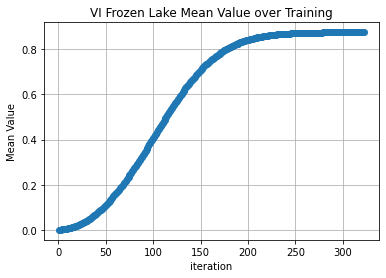

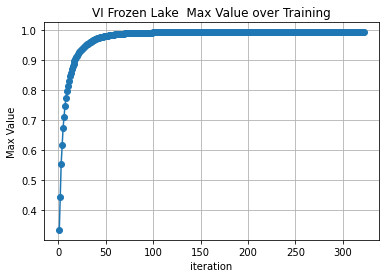

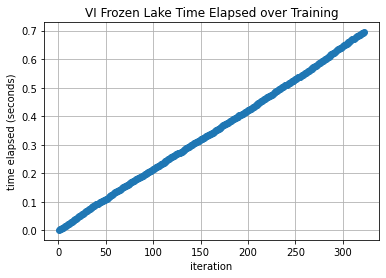

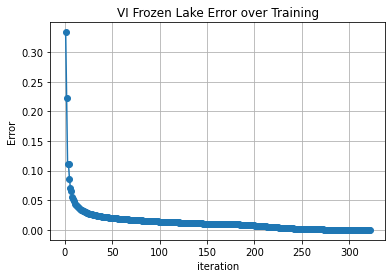

In [208]:
#plot Best Run
fl32_vi = ValueIteration(FL32_T, FL32_R, gamma=0.999, epsilon=1e-4,max_iter=100000)
fl32_vi.run()
fl32_vi_curated_results = make_time_array(fl32_vi.run_stats, ["Mean V", "Max V", "Iteration", "Error"])
num_iters = len(fl32_vi_curated_results["Mean V"])
plot_simple_data(fl32_vi_curated_results["Iteration"], fl32_vi_curated_results["Mean V"], 
                 "iteration", "Mean Value", "VI Frozen Lake Mean Value over Training", figure_size=(6,4))
plot_simple_data(fl32_vi_curated_results["Iteration"], fl32_vi_curated_results["Max V"], 
                 "iteration", "Max Value", "VI Frozen Lake  Max Value over Training", figure_size=(6,4))
plot_simple_data(fl32_vi_curated_results["Iteration"], fl32_vi_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "VI Frozen Lake Time Elapsed over Training", figure_size=(6,4))
plot_simple_data(fl32_vi_curated_results["Iteration"], fl32_vi_curated_results["Error"], 
                 "iteration", "Error", "VI Frozen Lake Error over Training", figure_size=(6,4))

In [214]:
interest = ['gamma', 'epsilon', 'time', 'iterations', 'reward']
df1 = vi_data_FL4[interest]
df1.columns = ['gamma', 'epsilon', 'time_4x4', 'iterations_4x4', 'reward_4x4']
df2 = vi_data_FL8[interest]
df2.columns = ['gamma_8x8', 'epsilon_8x8', 'time_8x8', 'iterations_8x8', 'reward_8x8']
df2.drop('gamma_8x8', axis=1, inplace=True)
df2.drop('epsilon_8x8', axis=1, inplace=True)
df3 = vi_data_FL32[interest]
df3.columns = ['gamma_32x32', 'epsilon_32x32', 'time_32x32', 'iterations_32x32', 'reward_32x32']
df3.drop('gamma_32x32', axis=1, inplace=True)
df3.drop('epsilon_32x32', axis=1, inplace=True)
df3

,time_32x32,iterations_32x32,reward_32x32
0,0.006999,3.0,0.376667
1,0.018024,7.0,0.378920
2,0.017999,8.0,0.378925
3,0.021995,10.0,0.378927
4,0.012048,6.0,0.463787
5,0.033000,14.0,0.467042
6,0.044005,18.0,0.467059
7,0.052999,22.0,0.467060
8,0.036000,15.0,0.699524
9,0.093001,45.0,0.709914


In [215]:
result = pd.concat([df1, df2, df3], axis=1)
result

cm = seaborn.light_palette('green', as_cmap='True')
s = result.style.background_gradient(cmap=cm)
s

,gamma,epsilon,time_4x4,iterations_4x4,reward_4x4,time_8x8,iterations_8x8,reward_8x8,time_32x32,iterations_32x32,reward_32x32
0,0.300000,0.010000,0.000998,3.000000,0.373333,0.001036,3.000000,0.373333,0.006999,3.000000,0.376667
1,0.300000,0.000100,0.000000,7.000000,0.375096,0.001000,6.000000,0.375037,0.018024,7.000000,0.378920
2,0.300000,0.000010,0.000000,8.000000,0.375101,0.001038,8.000000,0.375058,0.017999,8.000000,0.378925
3,0.300000,0.000001,0.001000,10.000000,0.375103,0.000999,10.000000,0.375059,0.021995,10.000000,0.378927
4,0.600000,0.010000,0.000000,5.000000,0.442667,0.001130,5.000000,0.442133,0.012048,6.000000,0.463787
5,0.600000,0.000100,0.000964,12.000000,0.447600,0.000998,12.000000,0.446539,0.033000,14.000000,0.467042
6,0.600000,0.000010,0.000999,16.000000,0.447645,0.001007,16.000000,0.446584,0.044005,18.000000,0.467059
7,0.600000,0.000001,0.000999,20.000000,0.447649,0.001037,20.000000,0.446588,0.052999,22.000000,0.467060
8,0.900000,0.010000,0.000000,10.000000,0.614142,0.001002,10.000000,0.604898,0.036000,15.000000,0.699524
9,0.900000,0.000100,0.002032,44.000000,0.638900,0.002970,46.000000,0.630385,0.093001,45.000000,0.709914


<h3> Policy Iteration </h3>

In [18]:
def policyIteration(t, r, gammas, showResults=False, max_iterations=300, policy_stat=True, p_size=4):
    env_p = env4
    if p_size ==8:
        env_p = env8
    
    t0 = time.time()
    
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)), columns=columns)
    
    print('gamma,\ttime,\titer,\treward')
    print(80*'_')
    
    testnum = 0
    for g in gammas:
        test = PolicyIteration(t, r, gamma=g, max_iter=max_iterations, eval_type="iterative") # eval_type="matrix"
        
        runs  = test.run()
        Time  = test.time
        iters = test.iter
        maxr  = runs[-1]['Max V']
                
        max_rewards, mean_rewards, errors = [], [], []
        for run in runs:
            max_rewards.append(run['Max V'])
            mean_rewards.append(run['Mean V'])
            errors.append(run['Error'])
        
        policy = np.array(test.policy)
        policy = policy.reshape(p_size,p_size)
        
        data['gamma'][testnum]        = g
        data['time'][testnum]         = Time
        data['iterations'][testnum]   = iters
        data['reward'][testnum]       = maxr
        data['mean_rewards'][testnum] = {tuple(mean_rewards)}
        data['max_rewards'][testnum]  = {tuple(max_rewards)}
        data['error'][testnum]        = {tuple(errors)}
        data['policy'][testnum]       = {test.policy}
        
        print('%.2f,\t%.2f,\t%d,\t%f' % (g, Time, iters, maxr))
        
        if showResults:
            title = 'frozenlake_pi_' + str(rows) + 'x' + str(cols) + '_g' + str(g)
            plot_lake(env_p, policy, title)
        
        testnum = testnum + 1
            
    endTime = time.time() - t0
    print('Time taken: %.2f' % endTime)
    
    if policy_stat:
        # see differences in policy
        policies = data['policy']

        for i,p in enumerate(policies):
            pol = list(p)[0]
            steps, steps_stddev, failures = get_score(env_p, pol, showResults)
            data['average_steps'][i] = steps
            data['steps_stddev'][i]  = steps_stddev
            data['success_pct'][i]   = 100-failures      
        
    # replace all nan's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

In [182]:
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999]
PI4_data  = policyIteration(FL4_T, FL4_R, gammas, showResults=False, policy_stat=True, p_size=4)

# pi4_data.head(20)

gamma,	time,	iter,	reward
________________________________________________________________________________
0.10,	0.00,	3,	0.345185
0.20,	0.00,	4,	0.358979
0.30,	0.00,	4,	0.375077
0.40,	0.00,	4,	0.394313
0.50,	0.00,	4,	0.417836
0.60,	0.00,	4,	0.447623
0.70,	0.00,	4,	0.487242
0.80,	0.00,	5,	0.544175
0.90,	0.00,	5,	0.639006
0.99,	0.01,	6,	0.862834
1.00,	0.01,	6,	0.931178
Time taken: 0.05


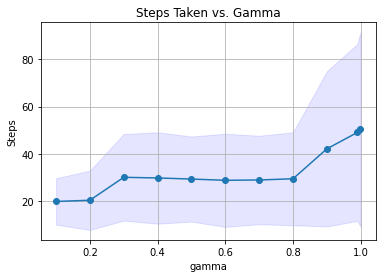

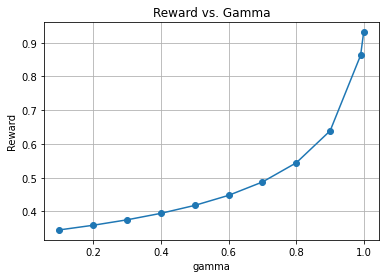

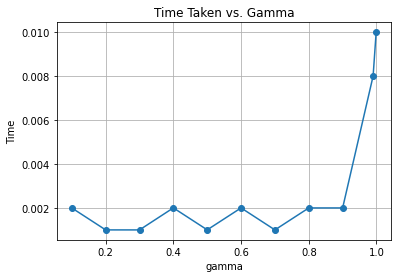

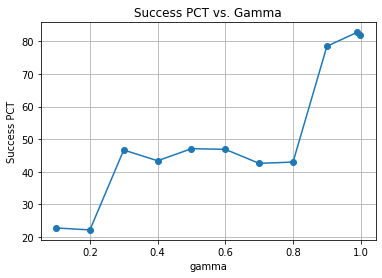

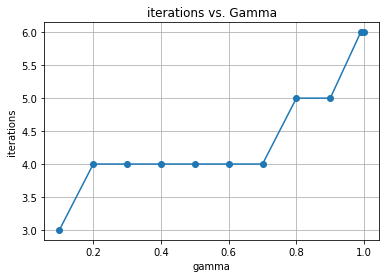

In [183]:
pi_plots(PI4_data,'gamma',gammas)

Best Result:
	Success = 82.80
	Gamma = 0.99


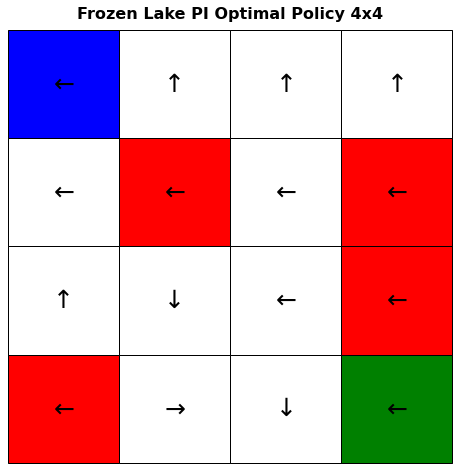

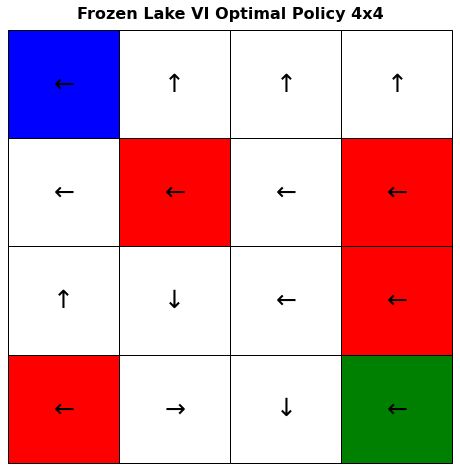

In [184]:
# Plot most successful gamma

# find the score with the highest success percentage and get its policy
bestRun = PI4_data['success_pct'].argmax()

best_policy = PI4_data['policy'][bestRun]
best_policy = np.array(list(best_policy)[0])
best_policy = best_policy.reshape(4, 4)

bestRun_v = vi_data_FL4['reward'].argmax()
best_v_policy = vi_data_FL4['policy'][bestRun_v]
best_v_policy = np.array(list(best_v_policy)[0])
best_v_policy = best_v_policy.reshape(4, 4)

# plot the policy
title='Frozen Lake PI Optimal Policy 4x4'
plot_lake(env4, best_policy, title)
# plot the policy
title='Frozen Lake VI Optimal Policy 4x4'
plot_lake(env4, best_v_policy, title)

# write all results to csv file
csvFile = 'frozen/PI_results.csv'
# pi_data.to_csv(csvFile)

print('Best Result:\n\tSuccess = %.2f\n\tGamma = %.2f' % (PI4_data['success_pct'].max(), PI4_data['gamma'][bestRun]))

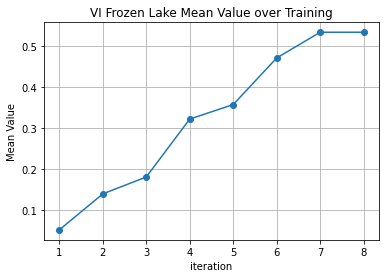

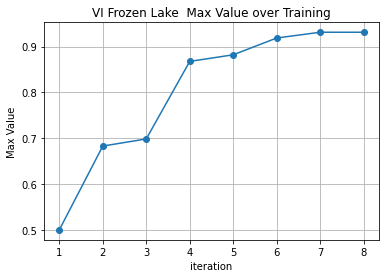

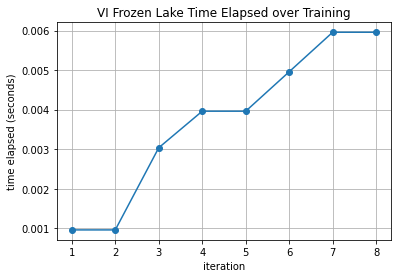

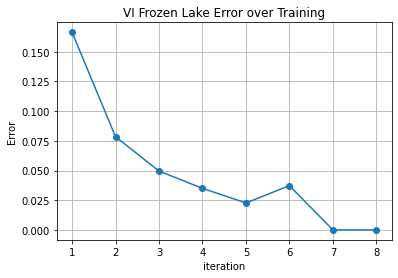

In [185]:
#plot Best Run
FL4_pi = PolicyIteration(FL4_T, FL4_R, gamma=0.999,max_iter=100000)
FL4_pi.run()
FL4_pi_curated_results = make_time_array(FL4_pi.run_stats, ["Mean V", "Max V", "Iteration", "Error"])
num_iters = len(FL4_pi_curated_results["Mean V"])
plot_simple_data(FL4_pi_curated_results["Iteration"], FL4_pi_curated_results["Mean V"], 
                 "iteration", "Mean Value", "VI Frozen Lake Mean Value over Training", figure_size=(6,4))
plot_simple_data(FL4_pi_curated_results["Iteration"], FL4_pi_curated_results["Max V"], 
                 "iteration", "Max Value", "VI Frozen Lake  Max Value over Training", figure_size=(6,4))
plot_simple_data(FL4_pi_curated_results["Iteration"], FL4_pi_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "VI Frozen Lake Time Elapsed over Training", figure_size=(6,4))
plot_simple_data(FL4_pi_curated_results["Iteration"], FL4_pi_curated_results["Error"], 
                 "iteration", "Error", "VI Frozen Lake Error over Training", figure_size=(6,4))

<h3>PI 8x8</h3>

In [25]:
#capped policy iteration to 300/
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999]
PI8_data  = policyIteration(FL8_T, FL8_R, gammas, showResults=False, policy_stat=False, p_size=8)

gamma,	time,	iter,	reward
________________________________________________________________________________
0.10,	0.00,	4,	0.345185
0.20,	0.00,	4,	0.358973
0.30,	0.00,	5,	0.375037
0.40,	0.00,	5,	0.394129
0.50,	0.00,	7,	0.417403
0.60,	0.00,	9,	0.446561
0.70,	0.00,	8,	0.484877
0.80,	0.00,	9,	0.539313
0.90,	0.01,	9,	0.630504
0.99,	0.03,	10,	0.877767
1.00,	0.10,	12,	0.981142
Time taken: 0.17


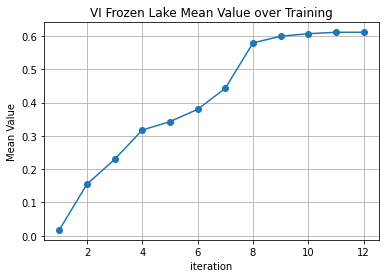

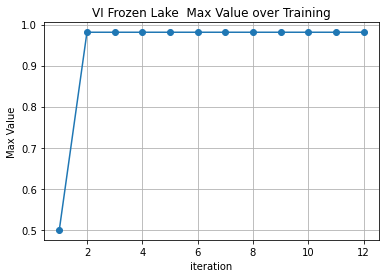

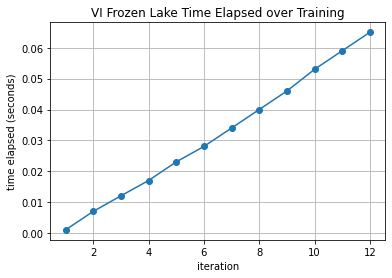

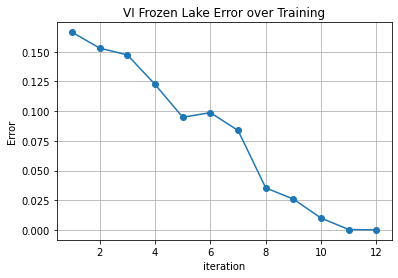

In [26]:
#plot Best Run
FL8_pi = PolicyIteration(FL8_T, FL8_R, gamma=0.999,max_iter=10000, eval_type="iterative")
FL8_pi.run()
FL8_pi_curated_results = make_time_array(FL8_pi.run_stats, ["Mean V", "Max V", "Iteration", "Error"])
num_iters = len(FL8_pi_curated_results["Mean V"])
plot_simple_data(FL8_pi_curated_results["Iteration"], FL8_pi_curated_results["Mean V"], 
                 "iteration", "Mean Value", "VI Frozen Lake Mean Value over Training", figure_size=(6,4))
plot_simple_data(FL8_pi_curated_results["Iteration"], FL8_pi_curated_results["Max V"], 
                 "iteration", "Max Value", "VI Frozen Lake  Max Value over Training", figure_size=(6,4))
plot_simple_data(FL8_pi_curated_results["Iteration"], FL8_pi_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "VI Frozen Lake Time Elapsed over Training", figure_size=(6,4))
plot_simple_data(FL8_pi_curated_results["Iteration"], FL8_pi_curated_results["Error"], 
                 "iteration", "Error", "VI Frozen Lake Error over Training", figure_size=(6,4))

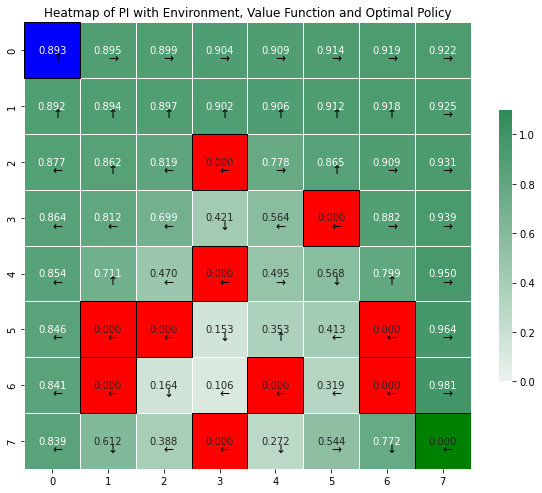

In [28]:
title= 'Heatmap of PI with Environment, Value Function and Optimal Policy'
fancy_visual(FL8_pi.V,FL8_pi.policy,grid=8,env=env8,title=title,fig_size_l=10, fig_size_w=10, save=False) 

In [216]:
#capped policy iteration to 300
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999]
PI32_data  = policyIteration(FL322_T, FL322_R, gammas, showResults=False, policy_stat=False, p_size=32)
# Not needed as we already know the impact

gamma,	time,	iter,	reward
________________________________________________________________________________
0.10,	0.06,	5,	0.345617
0.20,	0.07,	6,	0.360586
0.30,	0.07,	6,	0.378893
0.40,	0.08,	7,	0.401566
0.50,	0.14,	10,	0.430109
0.60,	0.19,	13,	0.467042
0.70,	0.30,	18,	0.516984
0.80,	0.58,	27,	0.589490
0.90,	1.00,	32,	0.709947
0.99,	3.05,	34,	0.947915
1.00,	8.60,	35,	0.991804
Time taken: 14.51


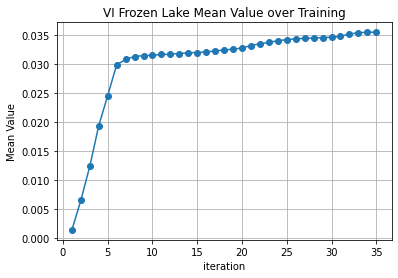

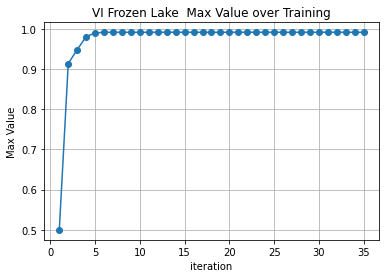

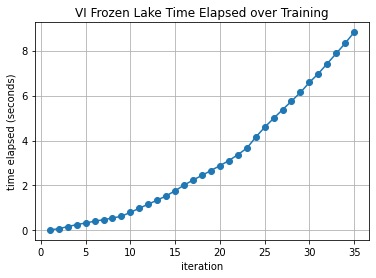

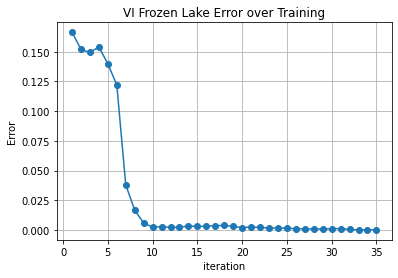

In [220]:
#plot Best Run
fl32_pi = PolicyIteration(FL322_T, FL322_R, gamma=0.999,max_iter=10000, eval_type="iterative")
fl32_pi.run()
fl32_pi_curated_results = make_time_array(fl32_pi.run_stats, ["Mean V", "Max V", "Iteration", "Error"])
num_iters = len(fl32_pi_curated_results["Mean V"])
plot_simple_data(fl32_pi_curated_results["Iteration"], fl32_pi_curated_results["Mean V"], 
                 "iteration", "Mean Value", "VI Frozen Lake Mean Value over Training", figure_size=(6,4))
plot_simple_data(fl32_pi_curated_results["Iteration"], fl32_pi_curated_results["Max V"], 
                 "iteration", "Max Value", "VI Frozen Lake  Max Value over Training", figure_size=(6,4))
plot_simple_data(fl32_pi_curated_results["Iteration"], fl32_pi_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "VI Frozen Lake Time Elapsed over Training", figure_size=(6,4))
plot_simple_data(fl32_pi_curated_results["Iteration"], fl32_pi_curated_results["Error"], 
                 "iteration", "Error", "VI Frozen Lake Error over Training", figure_size=(6,4))

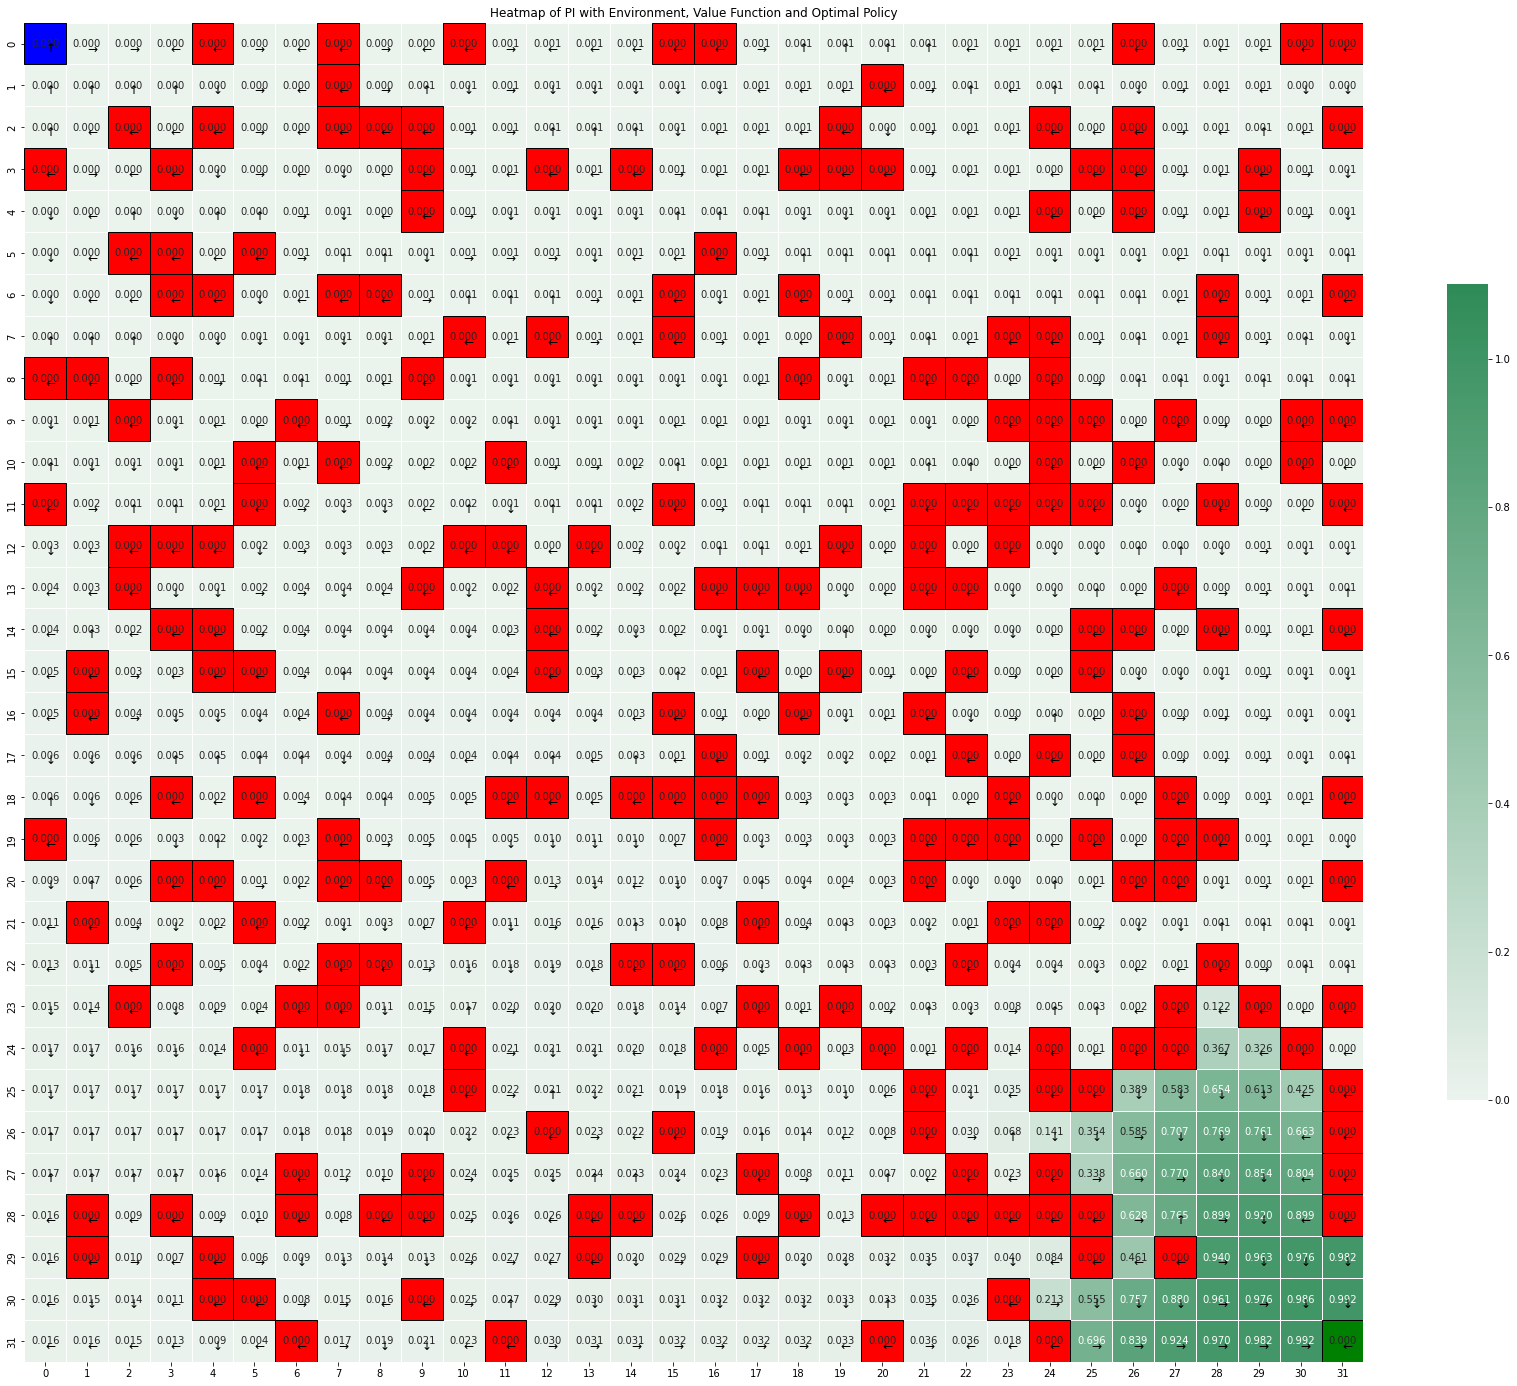

In [233]:
title= 'Heatmap of PI with Environment, Value Function and Optimal Policy'
fancy_visual(fl32_pi.V,fl32_pi.policy,grid=32,env=env32_2,title=title,fig_size_l=30, fig_size_w=30, save=True) 

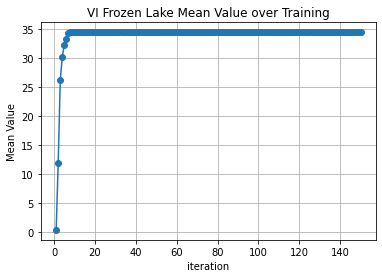

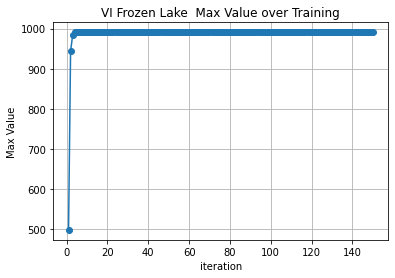

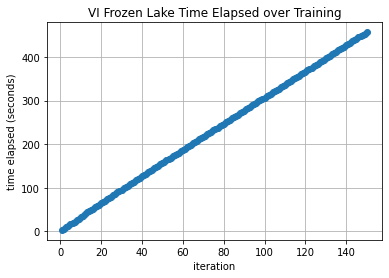

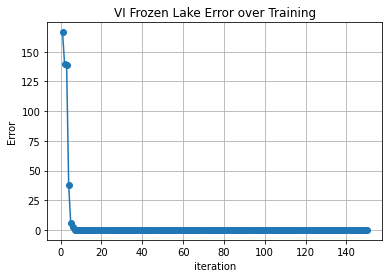

In [13]:
#Negative
fl32_pi_N = PolicyIteration(FL322_T, FL322_R_N, gamma=0.999,max_iter=150, eval_type="iterative")
fl32_pi_N.run()
fl32_pi_N_curated_results = make_time_array(fl32_pi_N.run_stats, ["Mean V", "Max V", "Iteration", "Error"])
num_iters = len(fl32_pi_N_curated_results["Mean V"])
plot_simple_data(fl32_pi_N_curated_results["Iteration"], fl32_pi_N_curated_results["Mean V"], 
                 "iteration", "Mean Value", "VI Frozen Lake Mean Value over Training", figure_size=(6,4))
plot_simple_data(fl32_pi_N_curated_results["Iteration"], fl32_pi_N_curated_results["Max V"], 
                 "iteration", "Max Value", "VI Frozen Lake  Max Value over Training", figure_size=(6,4))
plot_simple_data(fl32_pi_N_curated_results["Iteration"], fl32_pi_N_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "VI Frozen Lake Time Elapsed over Training", figure_size=(6,4))
plot_simple_data(fl32_pi_N_curated_results["Iteration"], fl32_pi_N_curated_results["Error"], 
                 "iteration", "Error", "VI Frozen Lake Error over Training", figure_size=(6,4))

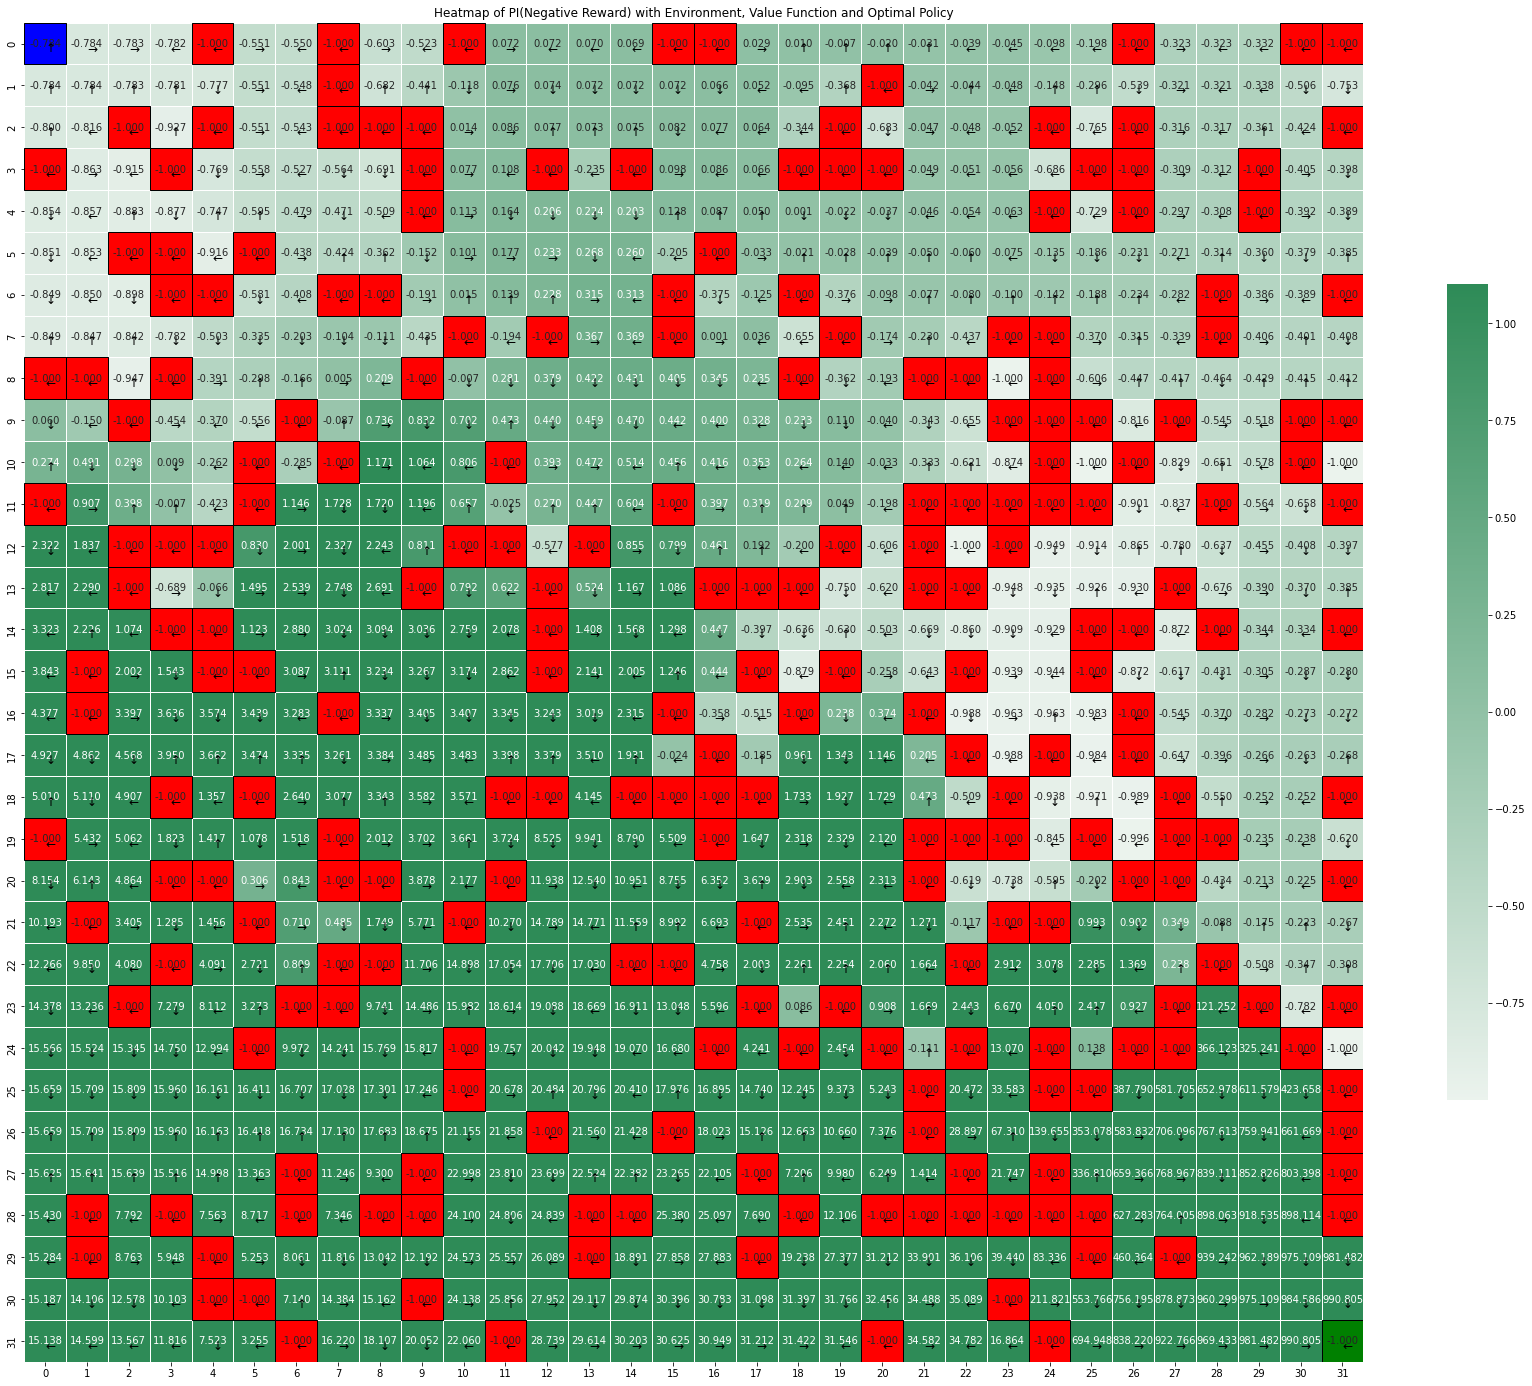

In [14]:
title= 'Heatmap of PI(Negative Reward) with Environment, Value Function and Optimal Policy'
fancy_visual(fl32_pi_N.V,fl32_pi_N.policy,grid=32,env=env32_2,title=title,fig_size_l=30, fig_size_w=30, save=True) 

In [15]:
interest = ['gamma']
df1 = PI4_data[interest]
df1['epsilon'] = 0.0001

interest2 = ['time', 'iterations', 'reward']
df2 = PI4_data[interest2]
df2.columns = ['time_4x4', 'iterations_4x4', 'reward_4x4']

df3 = PI8_data[interest2]
df3.columns = ['time_8x8', 'iterations_8x8', 'reward_8x8']

df4 = PI32_data[interest2]
df4.columns = ['time_32x32', 'iterations_32x32', 'reward_32x32']


NameError: name 'PI4_data' is not defined

In [219]:
result = pd.concat([df1, df2, df3, df4], axis=1)
result

cm = seaborn.light_palette('green', as_cmap='True')
s = result.style.background_gradient(cmap=cm)
s

,gamma,epsilon,time_4x4,iterations_4x4,reward_4x4,time_8x8,iterations_8x8,reward_8x8,time_32x32,iterations_32x32,reward_32x32
0,0.100000,0.000100,0.001999,3.000000,0.345185,0.001009,4.000000,0.345185,0.055716,5.000000,0.345617
1,0.200000,0.000100,0.000999,4.000000,0.358979,0.001084,4.000000,0.358973,0.068997,6.000000,0.360586
2,0.300000,0.000100,0.000998,4.000000,0.375077,0.001041,5.000000,0.375037,0.066002,6.000000,0.378893
3,0.400000,0.000100,0.002002,4.000000,0.394313,0.001000,5.000000,0.394129,0.076992,7.000000,0.401566
4,0.500000,0.000100,0.001002,4.000000,0.417836,0.000996,7.000000,0.417403,0.135000,10.000000,0.430109
5,0.600000,0.000100,0.002001,4.000000,0.447623,0.002034,9.000000,0.446561,0.191275,13.000000,0.467042
6,0.700000,0.000100,0.000999,4.000000,0.487242,0.001967,8.000000,0.484877,0.296994,18.000000,0.516984
7,0.800000,0.000100,0.001999,5.000000,0.544175,0.003034,9.000000,0.539313,0.581005,27.000000,0.589490
8,0.900000,0.000100,0.002000,5.000000,0.639006,0.004000,9.000000,0.630504,1.000968,32.000000,0.709947
9,0.990000,0.000100,0.008005,6.000000,0.862834,0.023993,10.000000,0.877767,3.052982,34.000000,0.947915


<h3>Q Learning</h3>

In [167]:
def qLearning(t, r, gammas, alphas, alpha_decays=[0.99], epsilon_decays=[0.99], n_iterations=[10000000], showResults=False, policy_stat=True, p_size=4):
    # create data structure to save off
    columns = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'time', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    numTests = len(gammas)*len(alphas)*len(alpha_decays)*len(epsilon_decays)*len(n_iterations)
    data = pd.DataFrame(0.0, index=np.arange(numTests), columns=columns)
    env_p = env4
    if p_size ==8:
        env_p = env8
    print('Gamma,\tAlpha,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for a in alphas:
            for a_decay in alpha_decays:
                for e_decay in epsilon_decays:
                    for n in n_iterations:
                        print('Test Num %d/%d' %(testNum+1, numTests))
                        print('Gamma: %.2f,\tAlpha: %.2f,\tAlpha Decay:%.3f,\tEpsilon Decay:%.3f,\tIterations:%d' 
                             %(g, a, a_decay, e_decay, n))
                        
                        test = QLearning(t, r, gamma=g, alpha=a, alpha_decay=a_decay, epsilon_decay=e_decay, n_iter=n)
                        
                        runs  = test.run()
                        time  = runs[-1]['Time']
                        iters = runs[-1]['Iteration']
                        maxR  = runs[-1]['Max V']
                        
                        max_rewards, mean_rewards, errors = [], [], []
                        for run in runs:
                            max_rewards.append(run['Max V'])
                            mean_rewards.append(run['Mean V'])
                            errors.append(run['Error'])
                        
                        policy = np.array(test.policy)
                        policy = policy.reshape(p_size,p_size)
                        
                        data['gamma'][testNum]         = g
                        data['alpha'][testNum]         = a
                        data['alpha_decay'][testNum]   = a_decay
                        data['epsilon_decay'][testNum] = e_decay
                        data['time'][testNum]          = time
                        data['iterations'][testNum]    = iters
                        data['reward'][testNum]        = maxR
                        data['mean_rewards'][testNum]  = {tuple(mean_rewards)}
                        data['max_rewards'][testNum]   = {tuple(max_rewards)}
                        data['error'][testNum]         = {tuple(errors)}
                        data['policy'][testNum]        = {test.policy}
                        
                        print('%.2f,\t%.2f,\t%.2f,\t%d,\t%f' % (g, a, time, iters, maxR))
                        
                        if showResults:
                            title = 'FrozenLake_QL_' + str(rows) + 'x' + str(cols) + '_g' + str(g) + '_a' + str(a) + '_adecay' + str(a_decay) + '_edecay' + str(e_decay) + '_iter' + str(n)
                            plot_lake(env_p, policy, title)
                        
                        testNum = testNum + 1
            
    # See differences in policy
    if policy_stat:
        policies = data['policy']

        for i,p in enumerate(policies):
            pol = list(p)[0]
            steps, steps_stddev, failures = get_score(env_p, pol, showResults)
            data['average_steps'][i] = steps
            data['steps_stddev'][i]  = steps_stddev
            data['success_pct'][i]   = 100-failures      
        
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

In [170]:
gammas   = [0.8, 0.99, 0.999]
alphas   = [0.01, 0.1, 0.2]
alpha_decays = [0.9, 0.999]
epsilon_decays = [0.9, 0.999]
iterations = [1e5, 1e6]


ql_data_fl4  = qLearning(FL4_T, FL4_R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=False, policy_stat=False, p_size=4)

# write all results to csv file
csvFile = '../data/QL_fl4_results.csv'
ql_data_fl4.to_csv(csvFile)



#ql_data.head()

Gamma,	Alpha,	Time,	Iter,	Reward
________________________________________________________________________________
Test Num 1/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:100000
0.80,	0.01,	3.51,	100000,	0.130131
Test Num 2/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:1000000
0.80,	0.01,	34.30,	1000000,	0.371032
Test Num 3/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:100000
0.80,	0.01,	3.50,	100000,	0.102571
Test Num 4/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:1000000
0.80,	0.01,	34.43,	1000000,	0.460721
Test Num 5/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.999,	Epsilon Decay:0.900,	Iterations:100000
0.80,	0.01,	3.58,	100000,	0.041365
Test Num 6/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.999,	Epsilon Decay:0.900,	Iterations:1000000
0.80,	0.01,	34.40,	1000000,	0.426008
Test Num 7/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.999,	Epsilon Decay:0.999,

0.99,	0.10,	34.04,	1000000,	0.478394
Test Num 61/72
Gamma: 0.99,	Alpha: 0.10,	Alpha Decay:0.999,	Epsilon Decay:0.900,	Iterations:100000
0.99,	0.10,	3.43,	100000,	0.091795
Test Num 62/72
Gamma: 0.99,	Alpha: 0.10,	Alpha Decay:0.999,	Epsilon Decay:0.900,	Iterations:1000000
0.99,	0.10,	34.81,	1000000,	0.487600
Test Num 63/72
Gamma: 0.99,	Alpha: 0.10,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:100000
0.99,	0.10,	3.70,	100000,	0.060435
Test Num 64/72
Gamma: 0.99,	Alpha: 0.10,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:1000000
0.99,	0.10,	34.38,	1000000,	0.372776
Test Num 65/72
Gamma: 0.99,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:100000
0.99,	0.20,	3.59,	100000,	0.073225
Test Num 66/72
Gamma: 0.99,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:1000000
0.99,	0.20,	34.79,	1000000,	0.416302
Test Num 67/72
Gamma: 0.99,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:100000
0.99,	0.20,	3.57,	100000,	0.076816
Test Num 68/72
G

(0.5914020616587086, 0.9, 0.1, 0.9, 0.9)


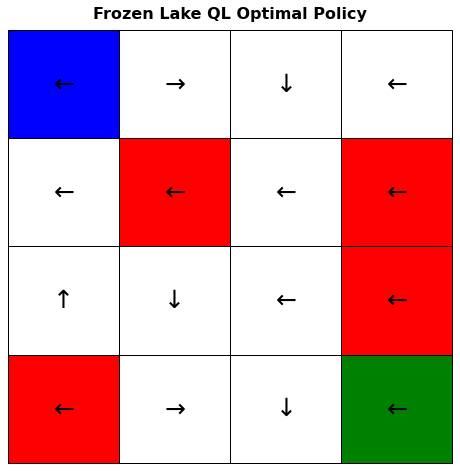

In [183]:
# Plot most successful gamma

# find the score with the highest success percentage and get its policy
bestRun = ql_data_fl4['reward'].argmax()

best_policy = ql_data_fl4['policy'][bestRun]

best_policy = np.array(list(best_policy)[0])
best_policy = best_policy.reshape(4, 4)

# # plot the policy
title='Frozen Lake QL Optimal Policy'
plot_lake(env4, best_policy, title)

# print('Best Result:\n\tSuccess = %.2f\n\tGamma = %.2f,\n\tAlpha = %.2f,\n\tAlpha Decay: %.3f,\n\tEpsilon Decay: %.3f,\n\tIterations: %.1E' 
#       % (ql_data_fl4['success_pct'].max(), ql_data_fl4['gamma'][bestRun], ql_data_fl4['alpha'][bestRun], ql_data_fl4['alpha_decay'][bestRun], ql_data_fl4['epsilon_decay'][bestRun]))

print((ql_data_fl4['reward'].max(), ql_data_fl4['gamma'][bestRun], ql_data_fl4['alpha'][bestRun], ql_data_fl4['alpha_decay'][bestRun], ql_data_fl4['epsilon_decay'][bestRun]))

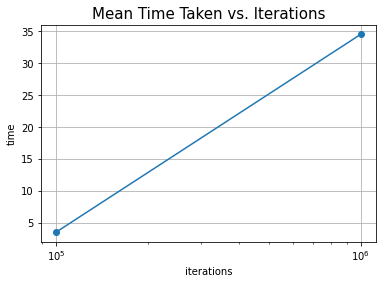

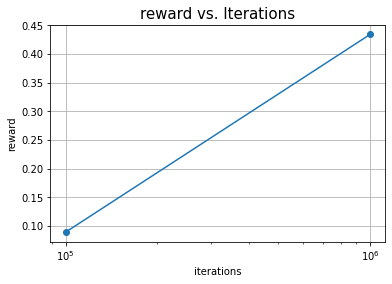

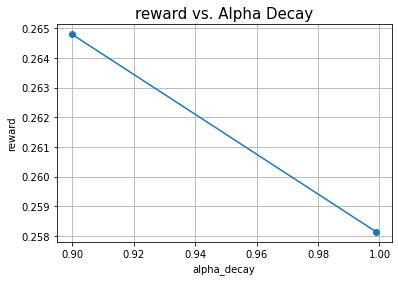

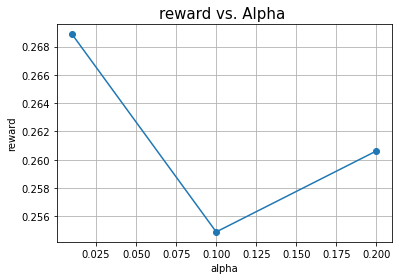

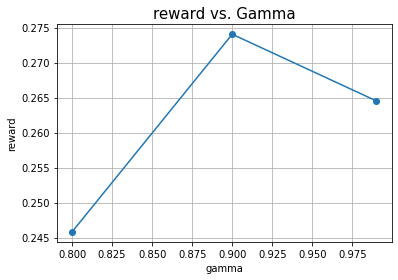

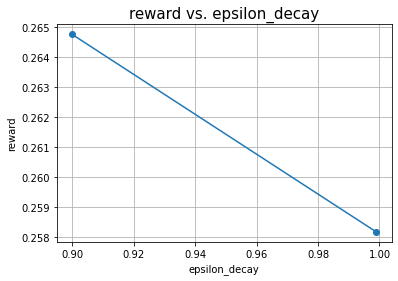

In [189]:
# Look at correlation matrix
interest = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'reward', 'time', 'success_pct']
# pick out hyperparameters and how succesful they were
df = ql_data_fl4[interest]

def plot_QL(dependent, independent, title=None, logscale=False):
    if dependent not in interest:
        print('Dependent variable not available')
        return
    if independent not in interest:
        print('Independent variable not available')
        return
    
    x = np.unique(df[dependent])
    y = []
    
    for i in x:
        y.append(df.loc[df[dependent] == i][independent].mean())
        
    fig = plt.figure(figsize=(6,4))
    plt.plot(x, y, 'o-')
    
    if title == None:
        title = independent + ' vs. ' + dependent
    plt.title(title, fontsize=15)
    plt.xlabel(dependent)
    plt.ylabel(independent)
    plt.grid(True)
    if logscale:
        plt.xscale('log')
    
    title='QL_' + independent + '_vs_' + dependent
    plt.show()
#     plt.savefig('./frozen/' + title + '.png', dpi=400)

# Plot values vs. Iterations
plot_QL('iterations', 'time', title='Mean Time Taken vs. Iterations', logscale=True)
plot_QL('iterations', 'reward', title='reward vs. Iterations', logscale=True)

# Plot alpha decay vs success pct
plot_QL('alpha_decay', 'reward', title='reward vs. Alpha Decay')

# Plot alpha decay vs success pct
plot_QL('alpha', 'reward', title='reward vs. Alpha ')

# Plot results vs. gamma
plot_QL('gamma', 'reward', title='reward vs. Gamma')

# Plot results vs. epsilon_decay
plot_QL('epsilon_decay', 'reward', title='reward vs. epsilon_decay')

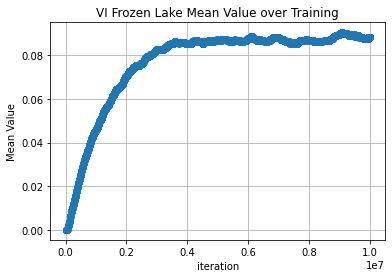

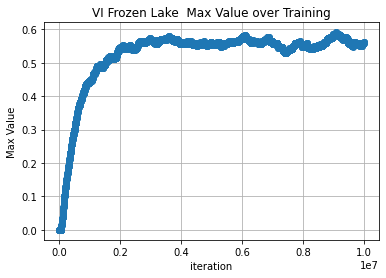

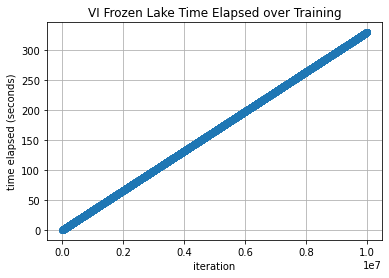

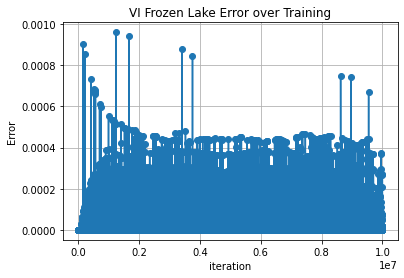

Wall time: 5min 29s


In [191]:
%%time
fl4_q = QLearning(FL4_T, FL4_R, gamma=.9, alpha=0.1, alpha_decay=0.9, epsilon_decay=0.9, n_iter=1e7)
fl4_q.run()
fl4_q_curated_results = make_time_array(fl4_q.run_stats, ["Mean V", "Max V", "Iteration", "Error"])
num_iters = len(fl4_q_curated_results["Mean V"])
plot_simple_data(fl4_q_curated_results["Iteration"], fl4_q_curated_results["Mean V"], 
                 "iteration", "Mean Value", "VI Frozen Lake Mean Value over Training", figure_size=(6,4))
plot_simple_data(fl4_q_curated_results["Iteration"], fl4_q_curated_results["Max V"], 
                 "iteration", "Max Value", "VI Frozen Lake  Max Value over Training", figure_size=(6,4))
plot_simple_data(fl4_q_curated_results["Iteration"], fl4_q_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "VI Frozen Lake Time Elapsed over Training", figure_size=(6,4))
plot_simple_data(fl4_q_curated_results["Iteration"], fl4_q_curated_results["Error"], 
                 "iteration", "Error", "VI Frozen Lake Error over Training", figure_size=(6,4))

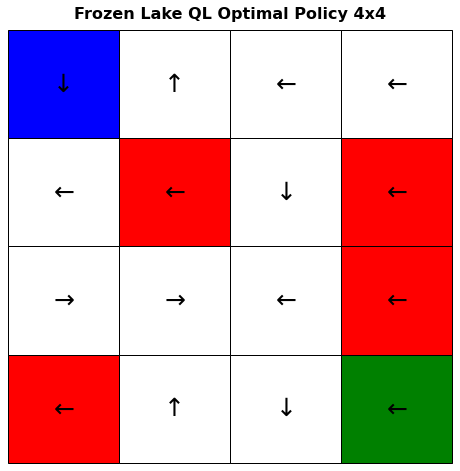

In [197]:
# plot the policy
best_policy = np.array(list(fl4_q.policy))
best_policy = best_policy.reshape(4, 4)

title='Frozen Lake QL Optimal Policy 4x4'
plot_lake(env4, best_policy, title)

In [276]:
%%time

#  def __init__(self, transitions, reward, gamma,
#                  alpha=0.1, alpha_decay=0.99, alpha_min=0.001,
#                  epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.99,
#                  n_iter=10000, skip_check=False, iter_callback=None,
#                  run_stat_frequency=None):
        
fl4_q = QLearning(FL4_T, FL4_R, gamma=.999, alpha=0.07, alpha_decay=0.999, epsilon_decay=0.9999, n_iter=1e5)
fl4_q.run()
fl4_q_curated_results = make_time_array(fl4_q.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
p_max_v= max(fl4_q_curated_results["Mean V"])

for i in range(1000):
    fl4_q.run()
    fl4_q_curated_results = make_time_array(fl4_q.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
    n_max_v= max(fl4_q_curated_results["Mean V"])
    l_check = 0
    if abs(n_max_v - p_max_v) <= 1e-4:
        l_check +=1
        print('l_check')
        print(n_max_v)
    else:
        l_check = 0
        p_max_v =  n_max_v
        print(p_max_v)
    if l_check > 10:
        print('converged')
        break
    else:
        ### reset alpha and epsilon since they will have decayed" 
        fl4_q.alpha = 0.07 # your prefered alpha
        fl4_q.epsilon = 1  #your prefered epsilon

0.01793773471541788
0.029100227370386235


KeyboardInterrupt: 

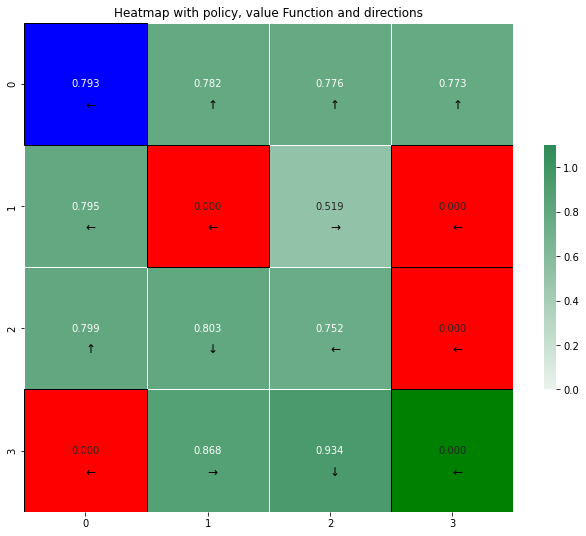

In [251]:
fancy_visual(fl4_q.V,fl4_q.policy,grid=4, env=env4) 

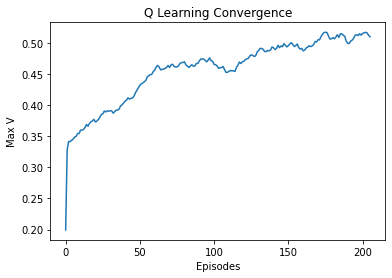

In [264]:
plt.plot(range(0,len(V_Max), 1),V_Max)
plt.xticks()
plt.ylabel('Max V') #set the label for y axis
plt.xlabel('Episodes') #set the label for x-axis
plt.title("Q Learning Convergence") #set the title of the graph
plt.show() #display the graph

In [267]:
print(V_Max)

[0.1994511095904643, 0.32776476223601125, 0.34134214459142137, 0.34117017046280895, 0.3434060749190299, 0.3450873088656645, 0.34841200602681177, 0.3494069098488119, 0.3541568806932885, 0.35412198664521133, 0.35962367440982224, 0.35971297534337043, 0.3605711492082964, 0.36385403338345657, 0.3687002850986849, 0.36597594346390483, 0.37033823177948527, 0.3731599162030499, 0.3742144889253079, 0.3769129544958116, 0.37283895262523004, 0.3740840276896745, 0.37671977177521865, 0.3801116066542741, 0.3846763989817784, 0.38577127300814035, 0.39023773958413965, 0.3888251816045253, 0.3907043883851368, 0.39001541676406887, 0.39090103765061013, 0.3904273451064138, 0.38691935885891615, 0.3891350828915525, 0.3917364098104367, 0.39191423482322196, 0.39349685457516526, 0.39857260965942576, 0.4003837471280775, 0.40310569871658536, 0.40606824382736934, 0.4077706821880975, 0.41146894370415504, 0.40948059117441504, 0.4107910769448635, 0.41103304001200397, 0.4141851658301035, 0.41952852840520166, 0.42380517407

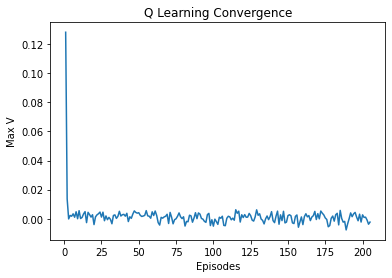

In [263]:
a = pd.DataFrame(V_Max)
b = a.rolling(window=2).apply(np.diff)
plt.plot(range(0,len(V_Max), 1),b )
plt.xticks()
plt.ylabel('Max V') #set the label for y axis
plt.xlabel('Episodes') #set the label for x-axis
plt.title("Q Learning Convergence") #set the title of the graph
plt.show() #display the graph

In [275]:
print(b.tail(50))

                0
156  2.538071e-03
157 -5.890384e-03
158 -2.302686e-03
159  1.195229e-03
160 -4.085917e-03
161  1.396954e-03
162  3.376557e-03
163  1.252523e-03
164  2.157550e-03
165 -1.344830e-03
166  1.125099e-03
167  2.050704e-03
168  5.015929e-03
169 -5.717604e-04
170  3.448753e-03
171 -1.187697e-04
172  5.254515e-03
173  3.784029e-03
174  2.606281e-03
175  4.972344e-04
176 -5.440207e-04
177 -5.573984e-03
178 -4.719504e-03
179  3.186824e-04
180  1.800841e-03
181 -1.714298e-03
182  2.721945e-03
183  3.683774e-03
184 -4.280808e-03
185  5.682146e-03
186  1.500650e-04
187 -2.381750e-03
188 -1.877743e-03
189 -7.740633e-03
190 -3.513157e-03
191 -3.820925e-07
192  3.967103e-03
193  1.367915e-03
194  3.313242e-03
195  4.308996e-03
196  1.106416e-03
197 -1.440750e-03
198  3.087517e-03
199 -2.336750e-03
200  2.628976e-03
201  8.647151e-04
202  1.039676e-03
203 -9.330532e-04
204 -3.811034e-03
205 -2.346229e-03


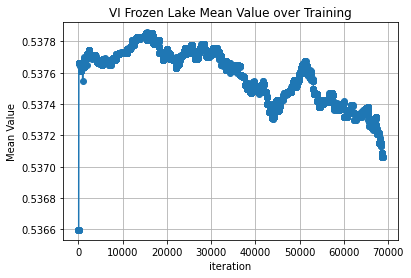

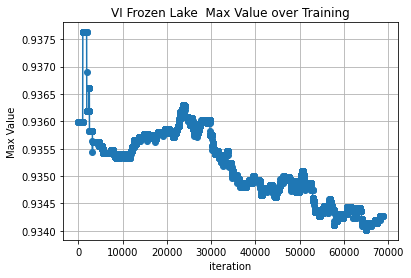

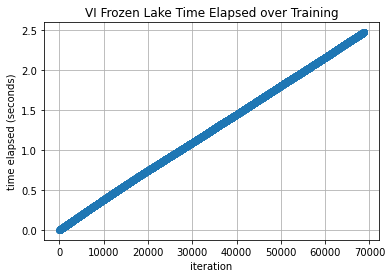

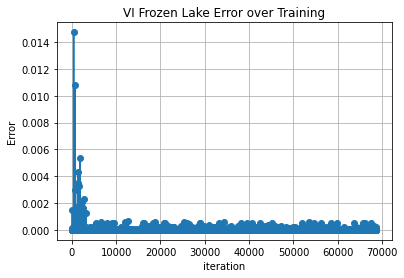

In [252]:
fl4_q_curated_results = make_time_array(fl4_q.run_stats, ["Mean V", "Max V", "Iteration", "Error"])
plot_simple_data(fl4_q_curated_results["Iteration"], fl4_q_curated_results["Mean V"], 
                 "iteration", "Mean Value", "VI Frozen Lake Mean Value over Training", figure_size=(6,4))
plot_simple_data(fl4_q_curated_results["Iteration"], fl4_q_curated_results["Max V"], 
                 "iteration", "Max Value", "VI Frozen Lake  Max Value over Training", figure_size=(6,4))
plot_simple_data(fl4_q_curated_results["Iteration"], fl4_q_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "VI Frozen Lake Time Elapsed over Training", figure_size=(6,4))
plot_simple_data(fl4_q_curated_results["Iteration"], fl4_q_curated_results["Error"], 
                 "iteration", "Error", "VI Frozen Lake Error over Training", figure_size=(6,4))

In [130]:
%%time
fl8_q = QLearning(FL8_T, FL8_R, gamma=.999, alpha=0.07, alpha_decay=0.99999, epsilon_decay=0.99, n_iter=1e5)
runs = fl8_q.run()
p_maxr  = runs[-1]['Max V']
# fl8_q_curated_results = make_time_array(fl8_q.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
# p_max_v= max(fl8_q_curated_results["Max V"])
V_Max =[]
V_Max.append(p_maxr)
for i in range(1000):
    runs = fl8_q.run()
    n_maxr  = runs[-1]['Max V']
#     fl8_q_curated_results = make_time_array(fl8_q.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
#     n_max_v= max(fl8_q_curated_results["Max V"])
    V_Max.append(n_maxr)
    if abs(n_maxr - p_maxr) <= 1e-15:
        print(n_maxr)
        print('converged')
        break
    else:
        p_maxr =  n_maxr
        print(p_maxr)

0.32776476223601125
0.34134214459142137
0.34117017046280895
0.3434060749190299
0.3450873088656645
0.34841200602681177
0.3494069098488119
0.3541568806932885
0.35412198664521133
0.35962367440982224
0.35971297534337043
0.3605711492082964
0.36385403338345657
0.3687002850986849
0.36597594346390483
0.37033823177948527
0.3731599162030499
0.3742144889253079
0.3769129544958116
0.37283895262523004
0.3740840276896745
0.37671977177521865
0.3801116066542741
0.3846763989817784
0.38577127300814035
0.39023773958413965
0.3888251816045253
0.3907043883851368
0.39001541676406887
0.39090103765061013
0.3904273451064138
0.38691935885891615
0.3891350828915525
0.3917364098104367
0.39191423482322196
0.39349685457516526
0.39857260965942576
0.4003837471280775
0.40310569871658536
0.40606824382736934
0.4077706821880975
0.41146894370415504
0.40948059117441504
0.4107910769448635
0.41103304001200397
0.4141851658301035
0.41952852840520166
0.42380517407056323
0.4276023792764603
0.4316981239021564
0.4340109389328491
0.43

KeyboardInterrupt: 

In [3]:
plt.plot(V_Max, marker='o' )
plt.xticks(range(0,len(V_Max)+1, 1))

plt.ylabel('Max V') #set the label for y axis
plt.xlabel('Episodes') #set the label for x-axis
plt.title("Q Learning Convergence") #set the title of the graph
plt.show() #display the graph

NameError: name 'V_Max' is not defined

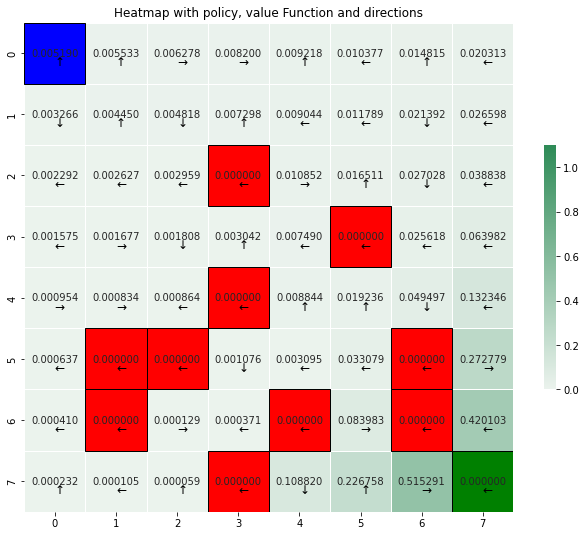

In [133]:
fancy_visual(fl8_q.V,fl8_q.policy,grid=8, env=env8) 

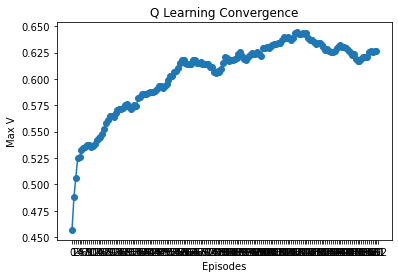

In [128]:


plt.plot(V_Max, marker='o' )
plt.xticks(range(0,len(V_Max)+1, 1))

plt.ylabel('Max V') #set the label for y axis
plt.xlabel('Episodes') #set the label for x-axis
plt.title("Q Learning Convergence") #set the title of the graph
plt.show() #display the graph

In [146]:
len(V_Max)

206

In [91]:
%%time
fl8_q = QLearning(FL8_T, FL8_R, gamma=.999, alpha=0.1, alpha_decay=0.9, epsilon_decay=0.9, n_iter=1e8)
fl8_q.run()
fl8_q_curated_results = make_time_array(fl8_q.run_stats, ["Mean V", "Max V", "Iteration", "Error"])
num_iters = len(fl8_q_curated_results["Mean V"])
plot_simple_data(fl8_q_curated_results["Iteration"], fl8_q_curated_results["Mean V"], 
                 "iteration", "Mean Value", "VI Frozen Lake Mean Value over Training", figure_size=(6,4))
plot_simple_data(fl8_q_curated_results["Iteration"], fl8_q_curated_results["Max V"], 
                 "iteration", "Max Value", "VI Frozen Lake  Max Value over Training", figure_size=(6,4))
plot_simple_data(fl8_q_curated_results["Iteration"], fl8_q_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "VI Frozen Lake Time Elapsed over Training", figure_size=(6,4))
plot_simple_data(fl8_q_curated_results["Iteration"], fl8_q_curated_results["Error"], 
                 "iteration", "Error", "VI Frozen Lake Error over Training", figure_size=(6,4))

KeyboardInterrupt: 

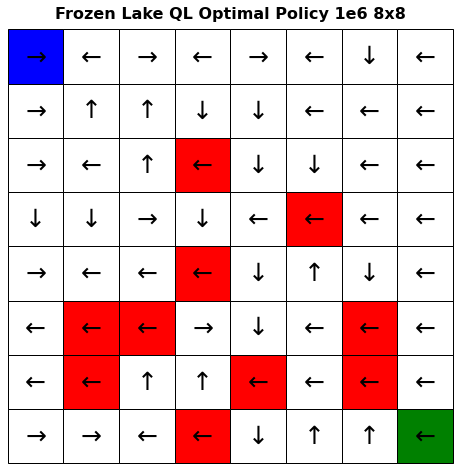

In [89]:
# plot the policy
best_policy = np.array(list(fl8_q.policy))
best_policy = best_policy.reshape(8, 8)

title='Frozen Lake QL Optimal Policy 1e6 8x8'
plot_lake(env8, best_policy, title)

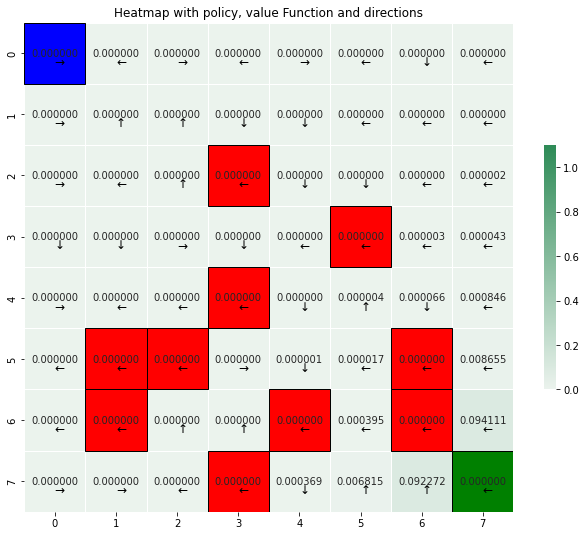

In [90]:
fancy_visual(fl8_q.V,fl8_q.policy,grid=8, env=env8) 

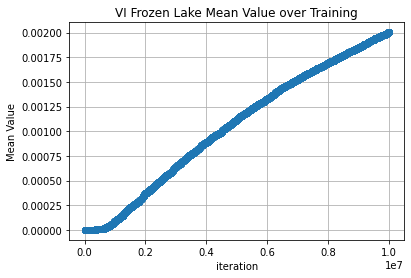

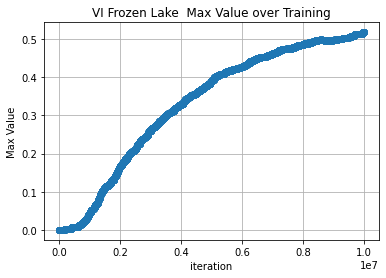

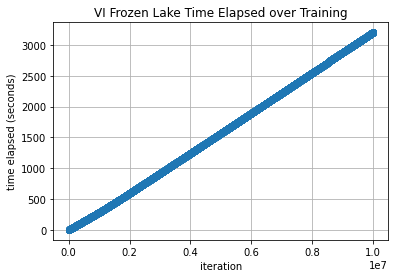

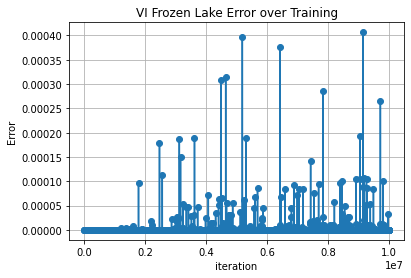

Wall time: 53min 24s


In [6]:
%%time
fl32_q = QLearning(FL32_T, FL32_R, gamma=.9, alpha=0.1, alpha_decay=0.9, epsilon_decay=0.9, n_iter=1e7)
fl32_q.run()
fl32_q_curated_results = make_time_array(fl32_q.run_stats, ["Mean V", "Max V", "Iteration", "Error"])
num_iters = len(fl32_q_curated_results["Mean V"])
plot_simple_data(fl32_q_curated_results["Iteration"], fl32_q_curated_results["Mean V"], 
                 "iteration", "Mean Value", "VI Frozen Lake Mean Value over Training", figure_size=(6,4))
plot_simple_data(fl32_q_curated_results["Iteration"], fl32_q_curated_results["Max V"], 
                 "iteration", "Max Value", "VI Frozen Lake  Max Value over Training", figure_size=(6,4))
plot_simple_data(fl32_q_curated_results["Iteration"], fl32_q_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "VI Frozen Lake Time Elapsed over Training", figure_size=(6,4))
plot_simple_data(fl32_q_curated_results["Iteration"], fl32_q_curated_results["Error"], 
                 "iteration", "Error", "VI Frozen Lake Error over Training", figure_size=(6,4))

In [179]:
# plot the policy
best_policy = np.array(list(fl32_q.policy))
best_policy = best_policy.reshape(32, 32)

best_policy

NameError: name 'fl32_q' is not defined

In [12]:
fl32_q.run_stats

[{'State': 669,
  'Action': 0,
  'Reward': 0.0,
  'Error': 0.0,
  'Time': 0.3099989891052246,
  'Alpha': 0.001,
  'Epsilon': 0.1,
  'Gamma': 0.9,
  'V[0]': 0.0,
  'Max V': 0.0,
  'Mean V': 0.0,
  'Iteration': 1000},
 {'State': 301,
  'Action': 0,
  'Reward': 0.0,
  'Error': 0.0,
  'Time': 0.5919985771179199,
  'Alpha': 0.001,
  'Epsilon': 0.1,
  'Gamma': 0.9,
  'V[0]': 0.0,
  'Max V': 0.0,
  'Mean V': 0.0,
  'Iteration': 2000},
 {'State': 113,
  'Action': 0,
  'Reward': 0.0,
  'Error': 0.0,
  'Time': 0.8579986095428467,
  'Alpha': 0.001,
  'Epsilon': 0.1,
  'Gamma': 0.9,
  'V[0]': 0.0,
  'Max V': 0.0,
  'Mean V': 0.0,
  'Iteration': 3000},
 {'State': 804,
  'Action': 0,
  'Reward': 0.0,
  'Error': 0.0,
  'Time': 1.1190364360809326,
  'Alpha': 0.001,
  'Epsilon': 0.1,
  'Gamma': 0.9,
  'V[0]': 0.0,
  'Max V': 0.0,
  'Mean V': 0.0,
  'Iteration': 4000},
 {'State': 95,
  'Action': 0,
  'Reward': 0.0,
  'Error': 0.0,
  'Time': 1.4340028762817383,
  'Alpha': 0.001,
  'Epsilon': 0.1,
  'Gamm

In [14]:
colors = {
    0: 'b',
    1: 'w',
    2: 'r',
    3: 'g'
}

labels =  {
            0: '←',
            1: '↓',
            2: '→',
            3: '↑'
}

def plot_lake2(policy, title='Frozen Lake',f_size=5):
    rows = 25
    cols = 25
    
    # reshape policy array to be 2-D - assumes 500 states...
    policy = np.array(list(policy)).reshape(f_size,f_size)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, xlim=(-.01, cols+0.01), ylim = (-.01, rows+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    
    for i in range(f_size):
        for j in range(f_size):
            y = f_size - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[policy[i,j]])
            ax.add_patch(p)
            
            text = ax.text(x+0.5, y+0.5, labels[policy[i, j]],
                           horizontalalignment='center', size=10, verticalalignment='center', color='w')
    
    plt.axis('off')

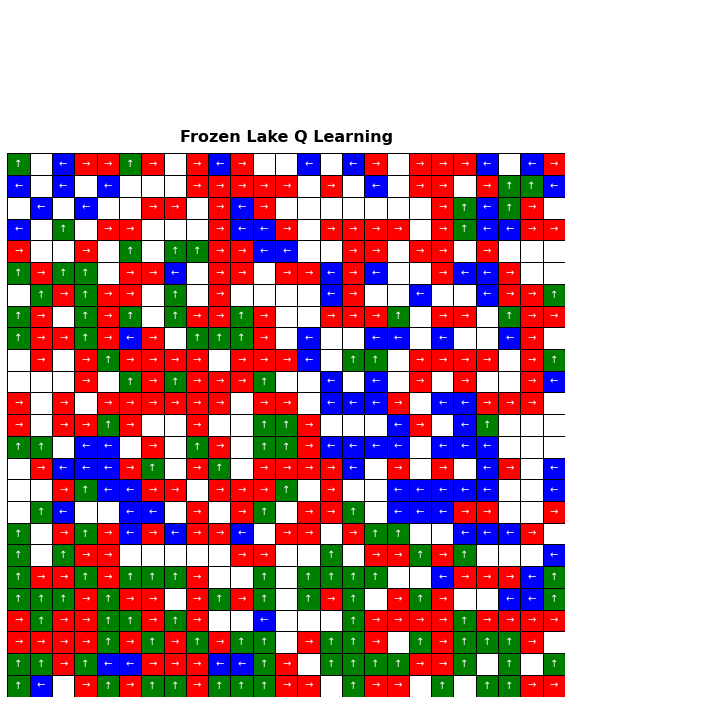

In [15]:
plot_lake2(fl32_q.policy,"Frozen Lake Q Learning",f_size=32)

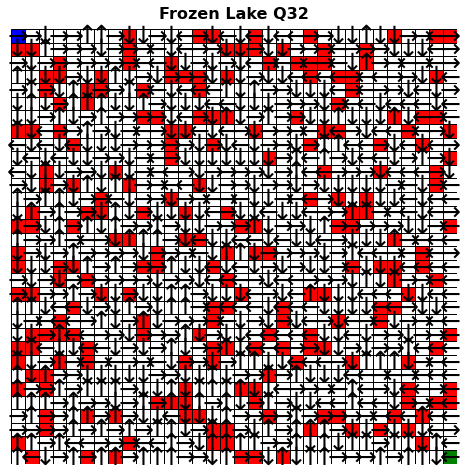

In [43]:
plot_lake2(env32_2, np.array(list(fl32_q.policy)).reshape(32,32), title='Frozen Lake Q32')